<a href="https://colab.research.google.com/github/JasonDepblu/potential-spork/blob/main/e8_of_content_based_filtering_explainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 7.3 MB/s eta 0:00:00


In [2]:
# %%
import time
import pandas as pd
import numpy as np
import random
import mpl_toolkits.axisartist as ast
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow import keras
import tensorflow as tf
from keras import layers, models, optimizers
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, auc
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import copy
import shap

In [3]:
# load the data
dsc_up_df = pd.read_csv(r'/content/dsc_up_e8.csv')
car_dict_df = pd.read_csv(r'/content/car_dict_e8.csv')

dsc_up_df = dsc_up_df.replace({np.NaN: 0})
car_dict_df = car_dict_df.replace({np.NaN: 0})

dsc_up = dsc_up_df.values
car_dict = car_dict_df.values

print(dsc_up.shape)
print(car_dict.shape)

(5520, 38)
(142, 160)


In [111]:
# load the predict data of year 21-23
dsc_up_pre_df = pd.read_csv(r'/content/dsc_up_e8_pre.csv')
car_dict_pre_df = pd.read_csv(r'/content/car_dict_e8_pre.csv')

dsc_up_pre_df = dsc_up_pre_df.replace({np.NaN: 0})
car_dict_pre_df = car_dict_pre_df.replace({np.NaN: 0})

dsc_up_pre = dsc_up_pre_df.values
car_dict_pre = car_dict_pre_df.values

print(dsc_up_pre.shape)
print(car_dict_pre.shape)


(5520, 38)
(142, 160)


In [112]:
# 提取特征列表
dsc_up_pre_features = dsc_up_pre_df.columns.tolist()
car_dict_pre_features = car_dict_pre_df.columns.tolist()

dsc_up_pre_features = dsc_up_pre_df.columns[1:29].tolist() # 提取第1至28个特征
car_dict_pre_features = car_dict_pre_df.columns[1:156].tolist() # 提取第1至155个特征

print(dsc_up_pre_features)
print(car_dict_pre_features)

['space', 'power', 'maneuverability', 'consumption', 'comfortableness', 'apperance', 'internal', 'costefficient', 'Pwork', 'Pshopping', 'Pkids', 'Ptraval', 'Pgoods', 'Pbussiness', 'Pldistance', 'Pdating', 'Pcross', 'Pracing', 'Pnettaxi', 'Prefit', 'Pteam', 'Pgirl', 'fdrivenkiloms', 'fcityid', 'fbudget', 'fprovinceid', 'driving _months', 'km/d']
['price', 'company', 'level', 'type_energy', 'quality_insurance_time', 'quality_insurance_mileage', 'quick_charge_time(80%)', 'slow_charge_time', 'power_car', 'torque_car', 'type_car', 'max_speed', 'time_for_100km_h', 'pure_electric_endurance_mileage', 'endurance_mileage', 'engine_type1', 'gears', 'mission', 'type_motor', 'total_torque_motor', 'maximum_power_of_front_motor', 'Maximum torque of front motor', 'Maximum torque of front motor.1', 'Maximum power of rear motor', 'Maximum torque of rear motor', 'Number of drive motors', 'Motor layout', 'Battery type', 'Battery group warranty1', 'Battery group warranty2', 'driving_pattern', 'Front suspen

In [6]:
num_cars = len(car_dict)
num_cars_pre = len(car_dict_pre)
print(f'The No. of cars in fundamental model dataset : {num_cars}')
print(f'The No. of cars in prediction dataset : {num_cars_pre}')

The No. of cars in fundamental model dataset : 142
The No. of cars in prediction dataset : 142


In [7]:
# balance dsc_up samples
dsc_up_bal = np.empty(shape=(1, dsc_up.shape[1]))

for i in range(num_cars):
  if len(dsc_up[dsc_up[:, 32] == i]) > 300:
    ran_row_bal = np.random.choice(np.arange(len(dsc_up[dsc_up[:, 32] == i])), size=300, replace=False)
    dsc_up_bali = dsc_up[dsc_up[:, 32] == i][ran_row_bal]
  else:
    dsc_up_bali = dsc_up[dsc_up[:, 32] == i]
  dsc_up_bal = np.concatenate((dsc_up_bal, dsc_up_bali), axis=0)
dsc_up = dsc_up_bal[1:]
print(dsc_up.shape)

(4945, 38)


In [8]:
# load the label
print(f'The shape of cars dict of the fundamental model dataset : {car_dict.shape}')
print(f'The shape of users list of the fundamental model dataset : {dsc_up.shape}')

print(f'The shape of cars dict of the prediction dataset : {car_dict_pre.shape}')
print(f'The shape of users list of the prediction dataset : {dsc_up_pre.shape}')

ys_up = dsc_up[:, 32]
ys_up_pre = dsc_up_pre[:, 32]
print(f'The label of which user choosed which car in fundamental dataset : {ys_up}')
print(f'The label of which user choosed which car in prediction dataset : {ys_up_pre}')

The shape of cars dict of the fundamental model dataset : (142, 160)
The shape of users list of the fundamental model dataset : (4945, 38)
The shape of cars dict of the prediction dataset : (142, 160)
The shape of users list of the prediction dataset : (5520, 38)
The label of which user choosed which car in fundamental dataset : [0 0 0 ... 141 141 141]
The label of which user choosed which car in prediction dataset : [37 38 121 ... 24 23 23]


In [9]:
# transfer the label of fundamental dataset to onehot_code
ys = copy.copy(ys_up.reshape(len(ys_up), 1))
ys -= 1
onehot_encoder = OneHotEncoder(sparse_output=False)
onehot_encoded = onehot_encoder.fit_transform(ys)
ys = onehot_encoded
print(f'The shape of the label of fundamental dataset to onehot_code : {ys.shape}')

# transfer the label of prediction dataset to onehot_code
ys_pre = copy.copy(ys_up_pre.reshape(len(ys_up_pre), 1))
ys_pre -= 1
onehot_encoder_pre = OneHotEncoder(sparse_output=False)
onehot_encoded_pre = onehot_encoder_pre.fit_transform(ys_pre)
ys_pre = onehot_encoded_pre
print(f'The shape of the label of prediction dataset to onehot_code : {ys_pre.shape}')

The shape of the label of fundamental dataset to onehot_code : (4945, 142)
The shape of the label of prediction dataset to onehot_code : (5520, 142)


In [10]:
# column of last feature from 0 and +1
col_last_feature_car = 156
# 80
col_last_feature_user = 29

car_unscaled = car_dict[:, 1:col_last_feature_car]
car_pre_unscaled = car_dict_pre[:, 1:col_last_feature_car]
user_unscaled = dsc_up[:, 1:col_last_feature_user]
user_pre_unscaled = dsc_up_pre[:, 1:col_last_feature_user]


# generate the gaussian random no. to budget feature
mu_budget = 0
sigma_budget = 1.5

for i in range(len(user_unscaled)):
    user_unscaled[i, 24] += random.gauss(mu_budget, sigma_budget)

for i in range(len(user_pre_unscaled)):
    user_pre_unscaled[i, 24] += random.gauss(mu_budget, sigma_budget)

# scaling the data
scalerCar = StandardScaler()
scalerCar.fit(car_dict[:, 1:col_last_feature_car])
car = scalerCar.transform(car_dict[:, 1:col_last_feature_car])
car_pre = scalerCar.transform(car_dict_pre[:, 1:col_last_feature_car])

scalerUser = StandardScaler()
scalerUser.fit(dsc_up[:, 1:col_last_feature_user])
user = scalerUser.transform(dsc_up[:, 1:col_last_feature_user])
user_pre = scalerUser.transform(dsc_up_pre[:, 1:col_last_feature_user])

print(np.allclose(car_unscaled.astype(float), scalerCar.inverse_transform(car)))
print(np.allclose(user_unscaled.astype(float), scalerUser.inverse_transform(user)))
print(np.allclose(car_pre_unscaled.astype(float), scalerCar.inverse_transform(car_pre)))
print(np.allclose(user_pre_unscaled.astype(float), scalerUser.inverse_transform(user_pre)))

True
True
True
True


In [11]:
car_unscaled[1, -1]

69.8

In [12]:
# func for generating num_items users of different cars
def gen_user_vecs(user_vec, num_items):
    """ given a user vector return:
        user predict matrix to match the size of item_vecs """
    user_vecs = np.tile(user_vec, (1, num_items))
    return user_vecs

def gen_car_vecs(car_vec, num_users):
    car_vecs = np.tile(car_vec, (num_users, 1))
    return car_vecs

PCA(n_components=10)
[0.07006126 0.06626383 0.06184579 0.05037927 0.04571003 0.03995805
 0.03936963 0.03879909 0.03773111 0.03726672]
PCA(n_components=15)
[0.32200143 0.13771627 0.10418725 0.06278649 0.04918918 0.03890272
 0.03254932 0.02665964 0.02334289 0.0206165  0.01733894 0.01606789
 0.0124296  0.01181082 0.01047612]


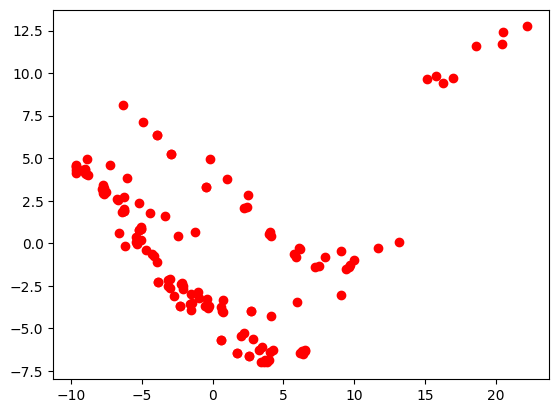

In [13]:
# pca analysis
pca_25 = PCA(n_components=10)
print(pca_25)
pca_25.fit(user)
print(pca_25.explained_variance_ratio_)

# %%
pca_30 = PCA(n_components=15)
print(pca_30)
pca_30.fit(car[:, 1:157])
print(pca_30.explained_variance_ratio_)
c_trans = pca_30.transform(car[:, 1:157])
plt.plot(c_trans[:, 0], c_trans[:, 1], 'ro')


In [14]:
# generate num_items users for different cars
user_vecs = gen_user_vecs(user, len(car_dict))
user_vecs = user_vecs.reshape(-1, user.shape[1])
car_vecs = gen_car_vecs(car, len(dsc_up))
ys = ys.reshape(-1, 1)
print(f'The shape of user matrix in fundamental dataset : {user_vecs.shape}')
print(f'The shape of car matrix in fundamental dataset : {car_vecs.shape}')
print(f'The shape of label matrix in fundamental dataset : {ys.shape}')

user_pre_vecs = gen_user_vecs(user_pre, len(car_dict_pre))
user_pre_vecs = user_pre_vecs.reshape(-1, user_pre.shape[1])
car_pre_vecs = gen_car_vecs(car_pre, len(dsc_up_pre))
ys_pre = ys_pre.reshape(-1, 1)
print(f'The shape of user matrix in prediction dataset : {user_pre_vecs.shape}')
print(f'The shape of car matrix in prediction dataset : {car_pre_vecs.shape}')
print(f'The shape of label matrix in fundamental dataset : {ys_pre.shape}')

The shape of user matrix in fundamental dataset : (702190, 28)
The shape of car matrix in fundamental dataset : (702190, 155)
The shape of label matrix in fundamental dataset : (702190, 1)
The shape of user matrix in prediction dataset : (783840, 28)
The shape of car matrix in prediction dataset : (783840, 155)
The shape of label matrix in fundamental dataset : (783840, 1)


In [15]:
print(ys[ys == 0].shape)
print(ys_pre[ys_pre == 0].shape)

(697245,)
(778320,)


In [16]:
randnum = random.randint(0, 100)
print(randnum)
random.seed(randnum)

64


In [17]:
# case 3
# Random choose the users which label is 0 in fundamental dataset

user_vecs_one = user_vecs[(ys == 1)[:, 0]]
user_vecs_zero = user_vecs[(ys == 0)[:, 0]]
num_users = user_vecs_one.shape[0]
num_zeros = user_vecs_zero.shape[0]
random.seed(randnum)

sample_row = np.random.choice(np.arange(num_zeros), size=np.ceil(num_users * 1.2).astype(int), replace=False)
user_vecs_zero = user_vecs_zero[sample_row]
user_vecs = np.concatenate((user_vecs_zero, user_vecs_one), axis=0)

random.seed(44)
shuffle_row = np.random.choice(np.arange(0,len(user_vecs)), len(user_vecs), replace=False)
user_vecs = user_vecs[shuffle_row]
print(f'The shape of the users data in fundatmental dataset after balancing : {user_vecs.shape}')

The shape of the users data in fundatmental dataset after balancing : (10879, 28)


In [18]:
# case3
# Random choose the cars which label is 0 in fundamental dataset

car_vecs_one = car_vecs[(ys == 1)[:, 0]]
car_vecs_zero = car_vecs[(ys == 0)[:, 0]][sample_row]
car_vecs = np.concatenate((car_vecs_zero, car_vecs_one), axis=0)

car_vecs = car_vecs[shuffle_row]
print(f'The shape of the cars data in fundatmental dataset after balancing : {car_vecs.shape}')

The shape of the cars data in fundatmental dataset after balancing : (10879, 155)


In [19]:
# case 3
# Random choose the label which is 0 in fundamental dataset
ys_one = ys[(ys == 1)[:, 0]]
ys_zero = ys[(ys == 0)[:, 0]][sample_row]
ys = np.concatenate((ys_zero, ys_one), axis=0)

ys = ys[shuffle_row]
print(f'The shape of label data in fundatmental dataset after balancing : {ys.shape}')

The shape of label data in fundatmental dataset after balancing : (10879, 1)


In [20]:
# Random choose the users which label is 0 in prediction dataset

user_pre_vecs_one = user_pre_vecs[(ys_pre == 1)[:, 0]]
user_pre_vecs_zero = user_pre_vecs[(ys_pre == 0)[:, 0]]
num_users_pre = user_pre_vecs_one.shape[0]
num_zeros_pre = user_pre_vecs_zero.shape[0]
random.seed(randnum)

sample_row_pre = np.random.choice(np.arange(num_zeros_pre), size=np.ceil(num_users_pre * 1.2).astype(int), replace=False)
user_pre_vecs_zero = user_pre_vecs_zero[sample_row_pre]
user_pre_vecs = np.concatenate((user_pre_vecs_zero, user_pre_vecs_one), axis=0)

random.seed(54)
shuffle_row_pre = np.random.choice(np.arange(0,len(user_pre_vecs)), len(user_pre_vecs), replace=False)
user_pre_vecs = user_pre_vecs[shuffle_row_pre]
# user_pre_vecs = user_vecs[shuffle_row_pre]??
print(f'The shape of the users data in fundatmental dataset after balancing : {user_pre_vecs.shape}')

The shape of the users data in fundatmental dataset after balancing : (12144, 28)


In [21]:
# Random choose the cars which label is 0 in prediction dataset

car_pre_vecs_one = car_pre_vecs[(ys_pre == 1)[:, 0]]
car_pre_vecs_zero = car_pre_vecs[(ys_pre == 0)[:, 0]][sample_row_pre]
car_pre_vecs = np.concatenate((car_pre_vecs_zero, car_pre_vecs_one), axis=0)

car_pre_vecs = car_pre_vecs[shuffle_row_pre]
print(f'The shape of the cars data in prediction dataset after balancing : {car_pre_vecs.shape}')

The shape of the cars data in prediction dataset after balancing : (12144, 155)


In [22]:
# Random choose the label which is 0 in prediction dataset
ys_pre_one = ys_pre[(ys_pre == 1)[:, 0]]
ys_pre_zero = ys_pre[(ys_pre == 0)[:, 0]][sample_row_pre]
ys_pre = np.concatenate((ys_pre_zero, ys_pre_one), axis=0)

ys_pre = ys_pre[shuffle_row_pre]
print(f'The shape of label data in prediction dataset after balancing : {ys_pre.shape}')

The shape of label data in prediction dataset after balancing : (12144, 1)


In [23]:
# case 3
# 对所有数据进行拆分以获取训练集和测试集
(user_train, user_test,
 car_train, car_test,
 ys_train, ys_test) = train_test_split(user_vecs, car_vecs, ys, train_size=0.8, shuffle=True, stratify=ys, random_state=2023)

# 对测试集进行进一步拆分以获得验证集和最终的测试集
(user_val, user_test,
 car_val, car_test,
 ys_val, ys_test) = train_test_split(user_test, car_test, ys_test, train_size=0.5, shuffle=True, stratify=ys_test, random_state=2023)

In [24]:
print(f"cars training data shape:{car_train.shape}")
print(f"cars validating data shape:{car_val.shape}")
print(f"cars testing data shape:{car_test.shape}")

print(f"users training data shape:{user_train.shape}")
print(f"users validating data shape:{user_val.shape}")
print(f"users testing data shape:{user_test.shape}")

print(f"ys training data shape:{ys_train.shape}")
print(f"ys validating data shape:{ys_val.shape}")
print(f"ys testing data shape:{ys_test.shape}")

cars training data shape:(8703, 155)
cars validating data shape:(1088, 155)
cars testing data shape:(1088, 155)
users training data shape:(8703, 28)
users validating data shape:(1088, 28)
users testing data shape:(1088, 28)
ys training data shape:(8703, 1)
ys validating data shape:(1088, 1)
ys testing data shape:(1088, 1)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 155)]                0         []                            
                                                                                                  
 sequential (Sequential)     (None, 32)                   44448     ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 32)                   76960     ['input_2[0][0]']             
                                                                                              

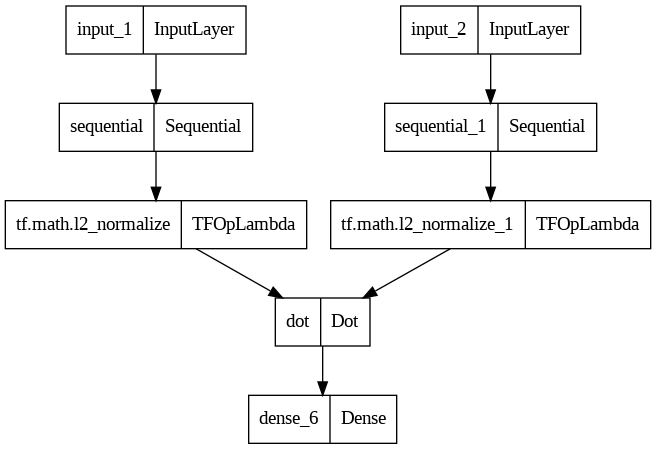

In [25]:
num_user_features = col_last_feature_user-1
num_car_features = col_last_feature_car-1
num_outputs = 32
tf.random.set_seed(1)
user_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs, activation='relu'),
])
car_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs, activation='relu'),
])

input_user = tf.keras.layers.Input(shape=(num_user_features))
vu = user_NN(input_user)
vu = tf.linalg.l2_normalize(vu, axis=1)

input_car = tf.keras.layers.Input(shape=(num_car_features))
vc = car_NN(input_car)
vc = tf.linalg.l2_normalize(vc, axis=1)

d_out = tf.keras.layers.Dot(axes=1)([vu, vc])
output = tf.keras.layers.Dense(1, activation='sigmoid')(d_out)

model = tf.keras.Model([input_user, input_car], output)
model.summary()
tf.keras.utils.plot_model(model, "/content/my_model.png")

In [26]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss=cost_fn)

In [27]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=5, # number of epochs to wait
                                                  restore_best_weights=True)


In [28]:
tf.random.set_seed(1)
# model.fit([user_train, car_train], ys_train, epochs=12)
history = model.fit([user_train, car_train], ys_train,
                    validation_data=([user_val, car_val], ys_val),
                    epochs=30,
                    callbacks=[early_stopping])


Epoch 1/30
272/272 [==============================] - 3s 4ms/step - loss: 0.2189 - val_loss: 0.1853
Epoch 2/30
272/272 [==============================] - 1s 3ms/step - loss: 0.1624 - val_loss: 0.1643
Epoch 3/30
272/272 [==============================] - 1s 3ms/step - loss: 0.1391 - val_loss: 0.1377
Epoch 4/30
272/272 [==============================] - 1s 3ms/step - loss: 0.1255 - val_loss: 0.1240
Epoch 5/30
272/272 [==============================] - 1s 3ms/step - loss: 0.1166 - val_loss: 0.1162
Epoch 6/30
272/272 [==============================] - 1s 3ms/step - loss: 0.1134 - val_loss: 0.1128
Epoch 7/30
272/272 [==============================] - 1s 3ms/step - loss: 0.1083 - val_loss: 0.1102
Epoch 8/30
272/272 [==============================] - 1s 3ms/step - loss: 0.1053 - val_loss: 0.1032
Epoch 9/30
272/272 [==============================] - 1s 3ms/step - loss: 0.1019 - val_loss: 0.1073
Epoch 10/30
272/272 [==============================] - 1s 4ms/step - loss: 0.1006 - val_loss: 0.1075

In [29]:
model.evaluate([user_val, car_val], ys_val)

34/34 [==============================] - 0s 2ms/step - loss: 0.1022


0.10222992300987244

In [30]:
model.evaluate([user_val[(ys_val == 0)[:, 0]], car_val[(ys_val == 0)[:, 0]]], ys_val[(ys_val == 0)[:, 0]])
model.evaluate([user_val[(ys_val == 1)[:, 0]], car_val[(ys_val == 1)[:, 0]]], ys_val[(ys_val == 1)[:, 0]])

16/16 [==============================] - 0s 2ms/step - loss: 0.0852


0.08522611856460571

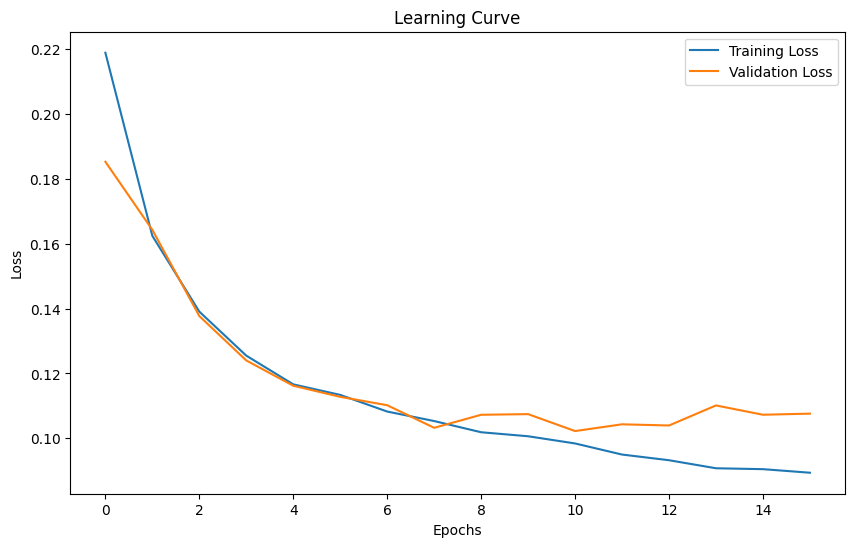

In [31]:
# import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


用validation set调参

In [32]:
ys_p_val = model.predict([[user_val, car_val]])

34/34 [==============================] - 0s 2ms/step


In [33]:
# print the confusion matrix & report of validation set
ys_p_val_binary = np.where(ys_p_val > 0.64, 1, 0)
confusion_val = confusion_matrix(ys_val, ys_p_val_binary)
print(confusion_val)
print(classification_report(ys_val, ys_p_val_binary))

[[523  71]
 [ 95 399]]
              precision    recall  f1-score   support

         0.0       0.85      0.88      0.86       594
         1.0       0.85      0.81      0.83       494

    accuracy                           0.85      1088
   macro avg       0.85      0.84      0.85      1088
weighted avg       0.85      0.85      0.85      1088



In [34]:
ys_test.shape

(1088, 1)

In [35]:
model.evaluate([user_test[(ys_test == 0)[:, 0]], car_test[(ys_test == 0)[:, 0]]], ys_test[(ys_test == 0)[:, 0]])
model.evaluate([user_test[(ys_test == 1)[:, 0]], car_test[(ys_test == 1)[:, 0]]], ys_test[(ys_test == 1)[:, 0]])

16/16 [==============================] - 0s 2ms/step - loss: 0.0913


0.09131637960672379

In [36]:
ys_p_test = model.predict([[user_test, car_test]])
ys_p_test_vs = np.concatenate((ys_p_test, ys_test), axis=1)
ys_test_df = pd.DataFrame(ys_p_test_vs)
ys_test_df.to_csv(r'/content/ys_p_test_6epoch.csv', encoding='UTF-8')

34/34 [==============================] - 0s 2ms/step


In [37]:
# print the confusion matrix & report of test set
print(confusion_matrix(ys_test, np.round(ys_p_test)))
print(classification_report(ys_test, np.round(ys_p_test)))

[[473 120]
 [ 46 449]]
              precision    recall  f1-score   support

         0.0       0.91      0.80      0.85       593
         1.0       0.79      0.91      0.84       495

    accuracy                           0.85      1088
   macro avg       0.85      0.85      0.85      1088
weighted avg       0.86      0.85      0.85      1088



In [38]:
ys_p_test_binary = np.where(ys_p_test > 0.64, 1, 0)
confusion_test = confusion_matrix(ys_test, ys_p_test_binary)
print(confusion_test)
print(classification_report(ys_test, ys_p_test_binary))

[[508  85]
 [ 91 404]]
              precision    recall  f1-score   support

         0.0       0.85      0.86      0.85       593
         1.0       0.83      0.82      0.82       495

    accuracy                           0.84      1088
   macro avg       0.84      0.84      0.84      1088
weighted avg       0.84      0.84      0.84      1088



AUC: 0.9144531316538063


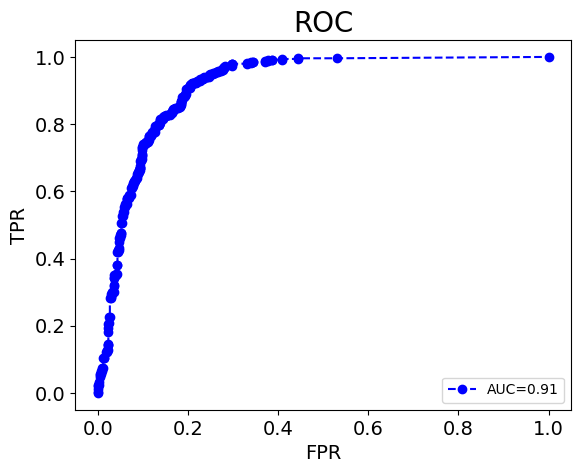

In [39]:
# calculate the auc & roc
FPR, TPR, thresholds = metrics.roc_curve(ys_test, ys_p_test)
AUC = auc(FPR, TPR)
print('AUC:',AUC)
plt.rc('font', family='', size=14)
plt.plot(FPR,TPR,label="AUC={:.2f}" .format(AUC),marker = 'o',color='b',linestyle='--')
plt.legend(loc=4, fontsize=10)
plt.title('ROC',fontsize=20)
plt.xlabel('FPR',fontsize=14)
plt.ylabel('TPR',fontsize=14)
plt.show()

# 可视化模型的权重

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
# 提取权重
user_weights = user_NN.get_weights()
car_weights = car_NN.get_weights()



In [ ]:
# 可视化函数
def visualize_weights(weights, network_name):
    for i, weight_matrix in enumerate(weights):
        # 权重的shape，如果是偏置项，则是一维数组
        if len(weight_matrix.shape) == 2:
            plt.figure(figsize=(12, 6))
            plt.imshow(weight_matrix, cmap='viridis')
            plt.colorbar()
            plt.title(f"{network_name} - Layer {i + 1} Weights")
            plt.show()
        else:
            plt.figure(figsize=(12, 2))
            plt.imshow(weight_matrix.reshape(1, -1), cmap='viridis', aspect='auto')
            plt.colorbar()
            plt.title(f"{network_name} - Layer {i + 1} Biases")
            plt.show()



In [ ]:
# 为用户神经网络和汽车神经网络的权重进行可视化
visualize_weights(user_weights, "User Neural Network")
visualize_weights(car_weights, "Car Neural Network")

#场景1～4 ##########

In [ ]:
ys_p_train = model.predict([[user_train, car_train]])

272/272 [==============================] - 1s 1ms/step


In [ ]:
# print the confusion matrix & report
print(confusion_matrix(ys_train, np.round(ys_p_train)))
print(classification_report(ys_train, np.round(ys_p_train)))

[[3542 1217]
 [ 322 3622]]
              precision    recall  f1-score   support

         0.0       0.92      0.74      0.82      4759
         1.0       0.75      0.92      0.82      3944

    accuracy                           0.82      8703
   macro avg       0.83      0.83      0.82      8703
weighted avg       0.84      0.82      0.82      8703



In [ ]:
# predict the users of year 21-23 whether buy the cars in scope
ys_p_pre = model.predict([user_pre_vecs, car_pre_vecs])

380/380 [==============================] - 1s 1ms/step


In [ ]:
# print the confusion matrix & report
print(confusion_matrix(ys_pre, np.round(ys_p_pre)))
print(classification_report(ys_pre, np.round(ys_p_pre)))

[[4929 1695]
 [ 453 5067]]
              precision    recall  f1-score   support

         0.0       0.92      0.74      0.82      6624
         1.0       0.75      0.92      0.83      5520

    accuracy                           0.82     12144
   macro avg       0.83      0.83      0.82     12144
weighted avg       0.84      0.82      0.82     12144



AUC: 0.9086418978199607


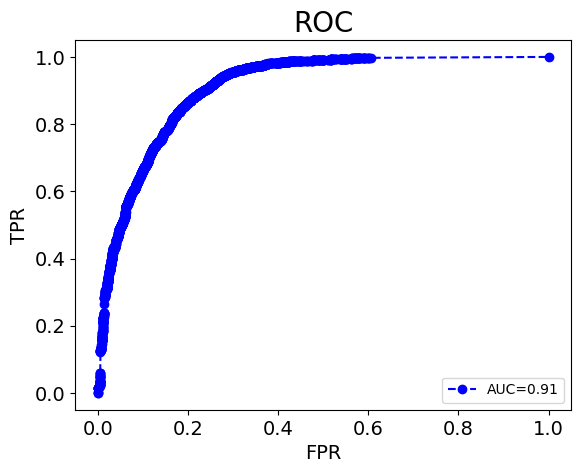

In [ ]:
# calculate the auc & roc
FPR, TPR, thresholds = metrics.roc_curve(ys_pre, ys_p_pre)
AUC = auc(FPR, TPR)
print('AUC:',AUC)
plt.rc('font', family='', size=14)
plt.plot(FPR,TPR,label="AUC={:.2f}" .format(AUC),marker = 'o',color='b',linestyle='--')
plt.legend(loc=4, fontsize=10)
plt.title('ROC',fontsize=20)
plt.xlabel('FPR',fontsize=14)
plt.ylabel('TPR',fontsize=14)
plt.show()

基于某个用户，预测不同的车的购买倾向

In [ ]:
list = []
for i in range(len(dsc_up)):
  if dsc_up[i, 32] == 7:
    list.append(i)
print(list)

[2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 220

In [ ]:
dsc_up[2047, :]

array([3358153, 3, 3, 3, 2, 3, 3, 4, 3, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2300, 3, 7.911861159554745, 5,
       3, 24, '宋Pro', 5178, 40569, 7, '2019款 1.5T 自动豪华型', 40569],
      dtype=object)

In [ ]:
# predict the new car of new performance for specific user
# define the cars and the user
row_car_dict = np.arange(0, num_cars)
row_user_dst = [2047]
new_car = car_unscaled[row_car_dict]
new_user = gen_car_vecs(user_unscaled[row_user_dst], len(row_car_dict))

# predict the new car of new performance
new_user_scal = scalerUser.transform(new_user)
new_car_scal = scalerCar.transform(new_car)
new_car_predict = model.predict([[new_user_scal, new_car_scal]])
print(f'target car is {dsc_up[row_user_dst, 33]}, car No. is {dsc_up[row_user_dst, 32]}')
for i in range(len(row_car_dict)):
    print(
        f'{i} :'
        f'{car_dict[row_car_dict, 91].reshape(-1, 1)[i]} : {np.round(new_car_predict[i],3)} : {np.round(new_car_predict[i], 0)}')

In [ ]:
new_y_predict = np.zeros((new_car_predict.shape))
new_y_predict [new_car_predict > 0.8] = 1
new_y_true = np.zeros((new_y_predict.shape))
new_y_true[row_car_dict == dsc_up[row_user_dst, 32]] = 1

print(confusion_matrix(new_y_true, new_y_predict))
print(classification_report(new_y_true, new_y_predict))


[[186   4]
 [  0   1]]
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       190
         1.0       0.20      1.00      0.33         1

    accuracy                           0.98       191
   macro avg       0.60      0.99      0.66       191
weighted avg       1.00      0.98      0.99       191



In [ ]:
dsc_up[row_user_dst, 32]

array([7], dtype=object)

In [ ]:
new_y_predict_vs = np.concatenate((new_y_predict, new_y_true), axis=1)
new_y_predict_vs = np.concatenate((new_car_predict, new_y_predict_vs), axis=1)
new_y_predict_df = pd.DataFrame(new_y_predict_vs)
new_y_predict_df.to_csv(r'/content/new_car_predict_vs.csv', encoding='UTF-8')

基于某款车预测不同用户的购买倾向

In [ ]:
row_car_dict = [7]
row_user_dst = np.arange(0, num_users)
new_car = gen_car_vecs(car_unscaled[row_car_dict], len(row_user_dst))
new_user = user_unscaled[row_user_dst]

new_user_scal = scalerUser.transform(new_user)
new_car_scal = scalerCar.transform(new_car)
new_car_predict = model.predict([[new_user_scal, new_car_scal]])

print(f'target car is {car_dict[row_car_dict, 91]}, car No. is {car_dict[row_car_dict, 92]}')
for i in range(min(len(row_user_dst), 200)):
    print(
        f'User{i} who has bought car:'
        f'{dsc_up[row_user_dst, 29].reshape(-1, 1)[i]} : {np.round(new_car_predict[i],3)} : {np.round(new_car_predict[i], 0)}')

In [ ]:
new_y_predict = np.zeros((new_car_predict.shape))
new_y_predict [new_car_predict > 0.86] = 1
new_y_true = np.zeros((new_y_predict.shape))
new_y_true[dsc_up[row_user_dst, 32] == row_car_dict] = 1

print(confusion_matrix(new_y_true, new_y_predict))
print(classification_report(new_y_true, new_y_predict))

[[29750 13445]
 [  212   788]]
              precision    recall  f1-score   support

         0.0       0.99      0.69      0.81     43195
         1.0       0.06      0.79      0.10      1000

    accuracy                           0.69     44195
   macro avg       0.52      0.74      0.46     44195
weighted avg       0.97      0.69      0.80     44195



In [ ]:
new_y_predict_vs = np.concatenate((new_y_predict, new_y_true), axis=1)
new_y_predict_vs = np.concatenate((new_car_predict, new_y_predict_vs), axis=1)
new_y_predict_vs = np.concatenate((dsc_up[row_user_dst, 32].reshape(-1, 1), new_y_predict_vs), axis=1)
new_y_predict_df = pd.DataFrame(new_y_predict_vs)
new_y_predict_df.to_csv(r'/content/new_user_predict_vs3.csv', encoding='UTF-8')

In [ ]:
new_y_predict [new_car_predict > 0.86].shape

(14233,)

修改某款车性能参数，预测不同用户的购买倾向

In [ ]:
# 32 宋DMIDMI110km
# 56 低配影酷
car_unscaled[56, 0]

11.98

In [ ]:
# base car parameters
row_car_dict = [56]
row_user_dst = np.arange(0, num_users)
new_car_one = car_unscaled[row_car_dict]
print(new_car_one)

[[11.98 7 1 2 1 0.0 0.0 130 270 1 190 8.35 0 735 3.0 350.0 165.0 350.0
  0.0 0.0 1.0 0 0 0 1 1 0 0 4680 1901 1670 2750 1617 1610 1915 1500 5 1 2
  2 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 4 1 1 3 1 4 1 1 1 1 0.0 1 3 1 1 1 1 1
  7.0 0 39.1 58.1 59.5 66.7]]


In [ ]:
# modify the paramters of some car
new_car_one[:, 0:14] = car_unscaled[32, 0:14]
print(new_car_one)

[[17.58 4 1 3 3 0.7 5.5 81 135 1 170 7.9 110 1443 3.0 350.0 165.0 350.0
  0.0 0.0 1.0 0 0 0 1 1 0 0 4680 1901 1670 2750 1617 1610 1915 1500 5 1 2
  2 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 4 1 1 3 1 4 1 1 1 1 0.0 1 3 1 1 1 1 1
  7.0 0 39.1 58.1 59.5 66.7]]


In [ ]:
new_car = gen_car_vecs(new_car_one, len(row_user_dst))
new_user = user_unscaled[row_user_dst]

new_user_scal = scalerUser.transform(new_user)
new_car_scal = scalerCar.transform(new_car)
new_car_predict = model.predict([[new_user_scal, new_car_scal]])

print(f'target car is {car_dict[row_car_dict, 81]}, car No. is {car_dict[row_car_dict, 82]}')
for i in range(min(len(row_user_dst), 100)):
    print(
        f'User{i} who has bought car:'
        f'{dsc_up[row_user_dst, 32].reshape(-1, 1)[i]} : {np.round(new_car_predict[i],3)} : {np.round(new_car_predict[i], 0)}')

In [ ]:
new_y_predict_modify = np.concatenate((dsc_up[row_user_dst, 32].reshape(-1, 1), new_car_predict), axis=1)
new_y_predict = np.zeros((new_car_predict.shape))
new_y_predict [new_car_predict > 0.8] = 1
new_y_predict_modify = np.concatenate((new_y_predict_modify, new_y_predict), axis=1)
new_y_predict_modify_df = pd.DataFrame(new_y_predict_modify)
new_y_predict_modify_df.to_csv(r'/content/new_user_predict_modify.csv', encoding='UTF-8')

In [ ]:
new_y_predict [new_car_predict > 0.8].shape

(3196,)

In [ ]:
dsc_up.shape

(9492, 33)

**修改某款车参数为未来热销车型参数，预测原有用户是否购买**

---



---



In [ ]:
dsc_up

In [ ]:
new_car = gen_car_vecs(new_car_one, len(row_user_dst))
new_user = user_unscaled[row_user_dst]

new_user_scal = scalerUser.transform(new_user)
new_car_scal = scalerCar.transform(new_car)
new_car_predict = model.predict([[new_user_scal, new_car_scal]])

print(f'target car is {car_dict_pre[row_car_dict, 91]}, car No. is {car_dict_pre[row_car_dict, 91]}')
for i in range(min(len(row_user_dst), 10000)):
    print(
        f'User{i} who has bought car:'
        f'{dsc_up[row_user_dst, 29].reshape(-1, 1)[i]} : {np.round(new_car_predict[i],3)} : {np.round(new_car_predict[i], 0)}')

155/155 [==============================] - 0s 1ms/step


NameError: ignored

In [ ]:
new_car_predict[new_car_predict > 0.8] = 1
new_y_predict_df = pd.DataFrame(new_car_predict)
new_y_predict_df.to_csv(r'/content/new_user_predict.csv', encoding='UTF-8')

In [ ]:
new_y_predict_modify = np.concatenate((dsc_up[row_user_dst, 29].reshape(-1, 1), new_car_predict), axis=1)
new_y_predict = np.zeros((new_car_predict.shape))
new_y_predict [new_car_predict > 0.8] = 1
new_y_predict_modify = np.concatenate((new_y_predict_modify, new_y_predict), axis=1)
new_y_predict_modify_df = pd.DataFrame(new_y_predict_modify)
new_y_predict_modify_df.to_csv(r'/content/new_user_predict_modify_RAV4.csv', encoding='UTF-8')

In [ ]:
new_y_predict [new_car_predict > 0.8].shape

(6663,)

In [ ]:
dsc_up.shape

(44195, 35)

修改用户地点，预测用户购买某款车的倾向变化

In [ ]:
row_car_dict = [11]
row_user_dst = np.arange(0, num_users)
new_car_one = car_unscaled[row_car_dict]
new_car = gen_car_vecs(new_car_one, len(row_user_dst))
new_user = user_unscaled[row_user_dst]

In [ ]:
# modify the place of users
# 吉林：26 长春：295
# 广东：1 广州：115
# 广东：1 深圳：195
new_user[:, (22,24)] = [(115, 1)]
print(new_user[0:10,(22,24)])

[[115 1]
 [115 1]
 [115 1]
 [115 1]
 [115 1]
 [115 1]
 [115 1]
 [115 1]
 [115 1]
 [115 1]]


In [ ]:
new_user[0]

array([3, 3, 2, 3, 2, 3, 3, 3, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 100, 115, 12.383482437349597, 1, 0, 7],
      dtype=object)

In [ ]:
new_user_scal = scalerUser.transform(new_user)
new_car_scal = scalerCar.transform(new_car)
new_car_predict = model.predict([[new_user_scal, new_car_scal]])

print(f'target car is {car_dict[row_car_dict, 81]}, car No. is {car_dict[row_car_dict, 82]}')
for i in range(min(len(row_user_dst), 100)):
    print(
        f'User{i} who has bought car:'
        f'{dsc_up[row_user_dst, 32].reshape(-1, 1)[i]} : {np.round(new_car_predict[i],3)} : {np.round(new_car_predict[i], 0)}')

In [ ]:
threshold_p = 0.23
new_y_predict [new_car_predict > threshold_p].shape

(460,)

In [ ]:
num_users

9492

In [ ]:
new_y_predict_modify = np.concatenate((dsc_up[row_user_dst, 32].reshape(-1, 1), new_car_predict), axis=1)
new_y_predict = np.zeros((new_car_predict.shape))
new_y_predict [new_car_predict > threshold_p] = 1
new_y_predict_modify = np.concatenate((new_y_predict_modify, new_y_predict), axis=1)
new_y_predict_modify_df = pd.DataFrame(new_y_predict_modify)
new_y_predict_modify_df.to_csv(r'/content/new_user_predict_modify_place.csv', encoding='UTF-8')

**others：**

In [ ]:
new_car_predict = np.concatenate((new_car_predict, dsc_up[0:, 30].reshape(-1, 1)), axis=1)
new_car_predict_df = pd.DataFrame(new_car_predict)
new_car_predict_df.to_csv(r'/content/new_car_predict3.csv', encoding='UTF-8')

In [ ]:
a = np.array([0,1,2])
b = np.array([1,2,3])
print(np.dot(a,b))

8


# **E8场景预测：针对爬取的已买MPV相关车型的用户，预测他们是否会购买E8**

In [40]:
e8_pre_df = pd.read_csv(r'/content/e8_para.csv')
e8_pre_df = e8_pre_df.replace({np.NaN: 0})
e8_pre = e8_pre_df.values
e8_pre.shape


(1, 158)

In [41]:
print(car_unscaled[0].shape)
print(col_last_feature_car)

(155,)
156


In [42]:
e8_pre = e8_pre[:, 1:col_last_feature_car]
print(e8_pre.shape)
row_user_dst = np.arange(0, num_users)

(1, 155)


In [43]:
new_car_one = e8_pre
print(e8_pre)
# new car parameters
# row_car_dict = [61]
# row_user_dst = np.arange(0, num_users)
# new_car_one = car_pre_unscaled[row_car_dict]
# print(new_car_one)

[[2.500e+01 1.000e+00 2.000e+00 4.000e+00 3.000e+00 1.000e+01 5.000e-01
  4.500e+00 1.030e+02 1.800e+02 1.000e+00 1.700e+02 9.800e+00 1.160e+02
  9.500e+02 8.000e+00 2.000e+00 1.000e+00 1.000e+00 1.340e+02 3.000e+02
  1.340e+02 3.000e+02 0.000e+00 0.000e+00 1.000e+00 1.000e+00 2.000e+00
  8.000e+00 1.500e+01 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00
  1.000e+00 4.920e+03 1.900e+03 1.760e+03 2.930e+03 1.618e+03 1.640e+03
  2.175e+03 7.000e+00 2.000e+00 1.000e+00 2.000e+00 0.000e+00 0.000e+00
  2.000e+00 2.000e+00 2.000e+00 2.000e+00 1.000e+00 1.000e+00 3.000e+00
  0.000e+00 5.000e+00 3.000e+00 1.000e+00 0.000e+00 0.000e+00 3.000e+00
  3.000e+00 2.000e+00 1.000e+00 0.000e+00 3.000e+00 1.000e+00 1.000e+00
  2.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
  2.000e+00 3.000e+00 1.000e+00 2.000e+00 3.000e+00 1.000e+00 0.000e+00
  2.000e+00 0.000e+00 1.000e+00 1.000e+00 2.000e+00 1.000e+00 2.000e+00
  5.000e+00 0.000e+00 2.000e+00 0.000e+00 0.000e+00 3.000e+00 3.

In [44]:
print(new_car_one[0, 0])

25.0


In [45]:
new_car = gen_car_vecs(new_car_one, len(row_user_dst))
new_user = user_unscaled[row_user_dst]

new_user_scal = scalerUser.transform(new_user)
new_car_scal = scalerCar.transform(new_car)
new_car_predict = model.predict([[new_user_scal, new_car_scal]])



155/155 [==============================] - 0s 2ms/step


In [46]:
print(row_user_dst.shape)
print(new_user_scal.shape)
print(new_car_scal.shape)

(4945,)
(4945, 28)
(4945, 155)


In [ ]:
# print(f'target car is {car_dict_pre[row_car_dict, 91]}, car No. is {car_dict_pre[row_car_dict, 91]}')
for i in range(min(len(row_user_dst), 10000)):
    print(
        f'User{i} who has bought car:'
        f'{dsc_up[row_user_dst, 29].reshape(-1, 1)[i]} : {np.round(new_car_predict[i],3)} : {np.round(new_car_predict[i], 0)}')

In [47]:
new_car_predict = np.concatenate((new_car_predict, dsc_up[0:, 29].reshape(-1, 1)), axis=1)
new_car_predict_df = pd.DataFrame(new_car_predict)
new_car_predict_df.to_csv(r'/content/new_car_predict25W顶配+.csv', encoding='UTF-8')

# 基于全数用户及全数MPV车型，通过SHAP筛选特征重要度

# 环境安装

In [ ]:
pip install shap --upgrade

In [ ]:
pip install tensorflow --upgrade

In [ ]:
pip uninstall tensorflow

In [ ]:
pip uninstall shap

In [ ]:
pip install tensorflow==2.10

In [ ]:
pip install shap==0.37

# GradientExplainer解释模型特征

In [48]:
num_users_pre

5520

In [49]:
num_cars_pre

142

In [174]:
background_data_user = user_train
background_data_car = car_train
print(background_data_user.shape)
print(background_data_car.shape)

(8703, 28)
(8703, 155)


In [175]:
explainer = shap.GradientExplainer(model, [background_data_user, background_data_car])

In [176]:
print(user_pre_vecs.shape)
print(car_pre_vecs.shape)

(12144, 28)
(12144, 155)


In [177]:
# 对一些数据计算SHAP值，例如整个训练集或一个子集
# shap_values = explainer.shap_values([user_pre_vecs, car_pre_vecs])
shap_values = explainer.shap_values([user_pre_vecs, car_pre_vecs])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [173]:
background_data_user_e8 = user_pre_vecs
background_data_car_e8 = car_pre_vecs
print(background_data_user_e8.shape)
print(background_data_car_e8.shape)

(12144, 28)
(12144, 155)


In [ ]:
explainer_e8 = shap.GradientExplainer(model, [background_data_user_e8, background_data_car_e8])

In [ ]:
shap_values_e8 = explainer_e8([new_user_scal, new_car_scal])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


# 使用deepExplainer解释模型特征

In [ ]:
background_data_user = user_train[:5000]
background_data_car = car_train[:5000]

In [ ]:
explainer_d = shap.DeepExplainer(model, [background_data_user, background_data_car])

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [ ]:
# 对一些数据计算SHAP值，例如整个训练集或一个子集
shap_values_d = explainer_d.shap_values([new_user_scal, car_train])

StagingError: ignored

# 识别贡献度最大的特征：

In [162]:
print(type(shap_values))
print(len(shap_values))

# 我们只检查第一个元素，因为您的输出显示shap_values的长度为1
first_element = shap_values[0]
print(type(first_element))
print(len(first_element))

# 现在我们看看这个列表的内容
for inner_value in first_element:
    print(type(inner_value))
    if isinstance(inner_value, np.ndarray):  # 如果它是一个ndarray，我们打印它的形状
        print(inner_value.shape)
    else:
        print(inner_value)  # 否则我们直接打印它的值



<class 'list'>
1
<class 'list'>
2
<class 'numpy.ndarray'>
(12144, 28)
<class 'numpy.ndarray'>
(12144, 155)


In [55]:
# 计算SHAP值的绝对值平均
meanab_shap_user = np.abs(shap_values[0][0]).mean(axis=0)
meanab_shap_car = np.abs(shap_values[0][1]).mean(axis=0)

In [56]:
meanab_shap_user

array([0.0024464 , 0.00244963, 0.00310337, 0.00476521, 0.00433288,
       0.00229992, 0.00484705, 0.00293824, 0.00649123, 0.00657777,
       0.00694166, 0.00576675, 0.00329622, 0.0037901 , 0.00530828,
       0.0053613 , 0.00299892, 0.00138041, 0.0018251 , 0.00234842,
       0.        , 0.00037817, 0.00273228, 0.00391089, 0.22199899,
       0.0045324 , 0.00367024, 0.0030305 ])

In [57]:
meanab_shap_car

array([0.00496226, 0.0058958 , 0.00125008, 0.00602141, 0.00734485,
       0.00257395, 0.00323539, 0.00336277, 0.0041255 , 0.00277965,
       0.        , 0.00120035, 0.0032857 , 0.00389664, 0.00451318,
       0.00181159, 0.00159863, 0.00508883, 0.006137  , 0.00335429,
       0.00191656, 0.00260495, 0.00262033, 0.00223113, 0.0022501 ,
       0.00205252, 0.00195294, 0.00194945, 0.00125546, 0.00124804,
       0.00251527, 0.        , 0.00217576, 0.00257025, 0.00304351,
       0.00261551, 0.00292295, 0.00244202, 0.00080445, 0.00302369,
       0.00244382, 0.00169421, 0.00221498, 0.0037826 , 0.00385912,
       0.00455184, 0.00337755, 0.00649863, 0.00330573, 0.00517233,
       0.00509974, 0.00251976, 0.00513099, 0.00094251, 0.00099173,
       0.00666554, 0.01085922, 0.00297401, 0.00386671, 0.00444697,
       0.00266701, 0.00063194, 0.0018569 , 0.0030013 , 0.0033232 ,
       0.00222609, 0.00588085, 0.00382882, 0.00407151, 0.00789737,
       0.00234367, 0.00228584, 0.00156229, 0.00420746, 0.00416

In [58]:
# 找到贡献度最高的前10个特征
top_features_user = meanab_shap_user.argsort()[-10:][::-1]
top_features_car = meanab_shap_car.argsort()[-10:][::-1]

In [59]:
print("Top 10 important features for User:", top_features_user)
print("Top 10 important features for Car:", top_features_car)

Top 10 important features for User: [24 10  9  8 11 15 14  6  3 25]
Top 10 important features for Car: [ 56  69  82   4  55 140  94  47  18   3]


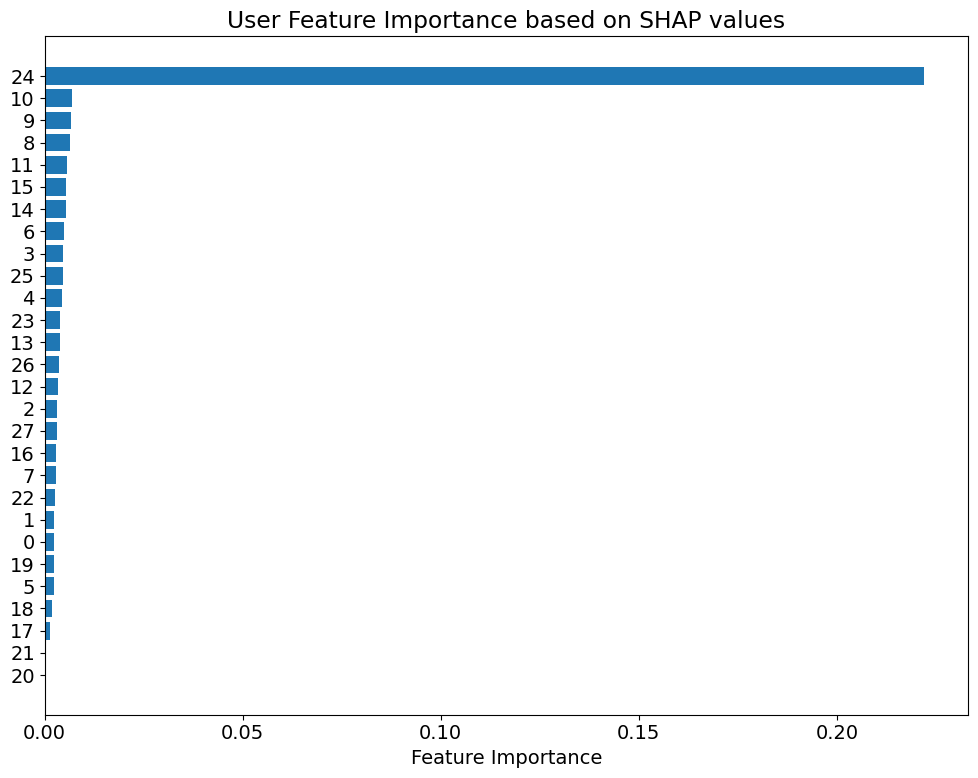

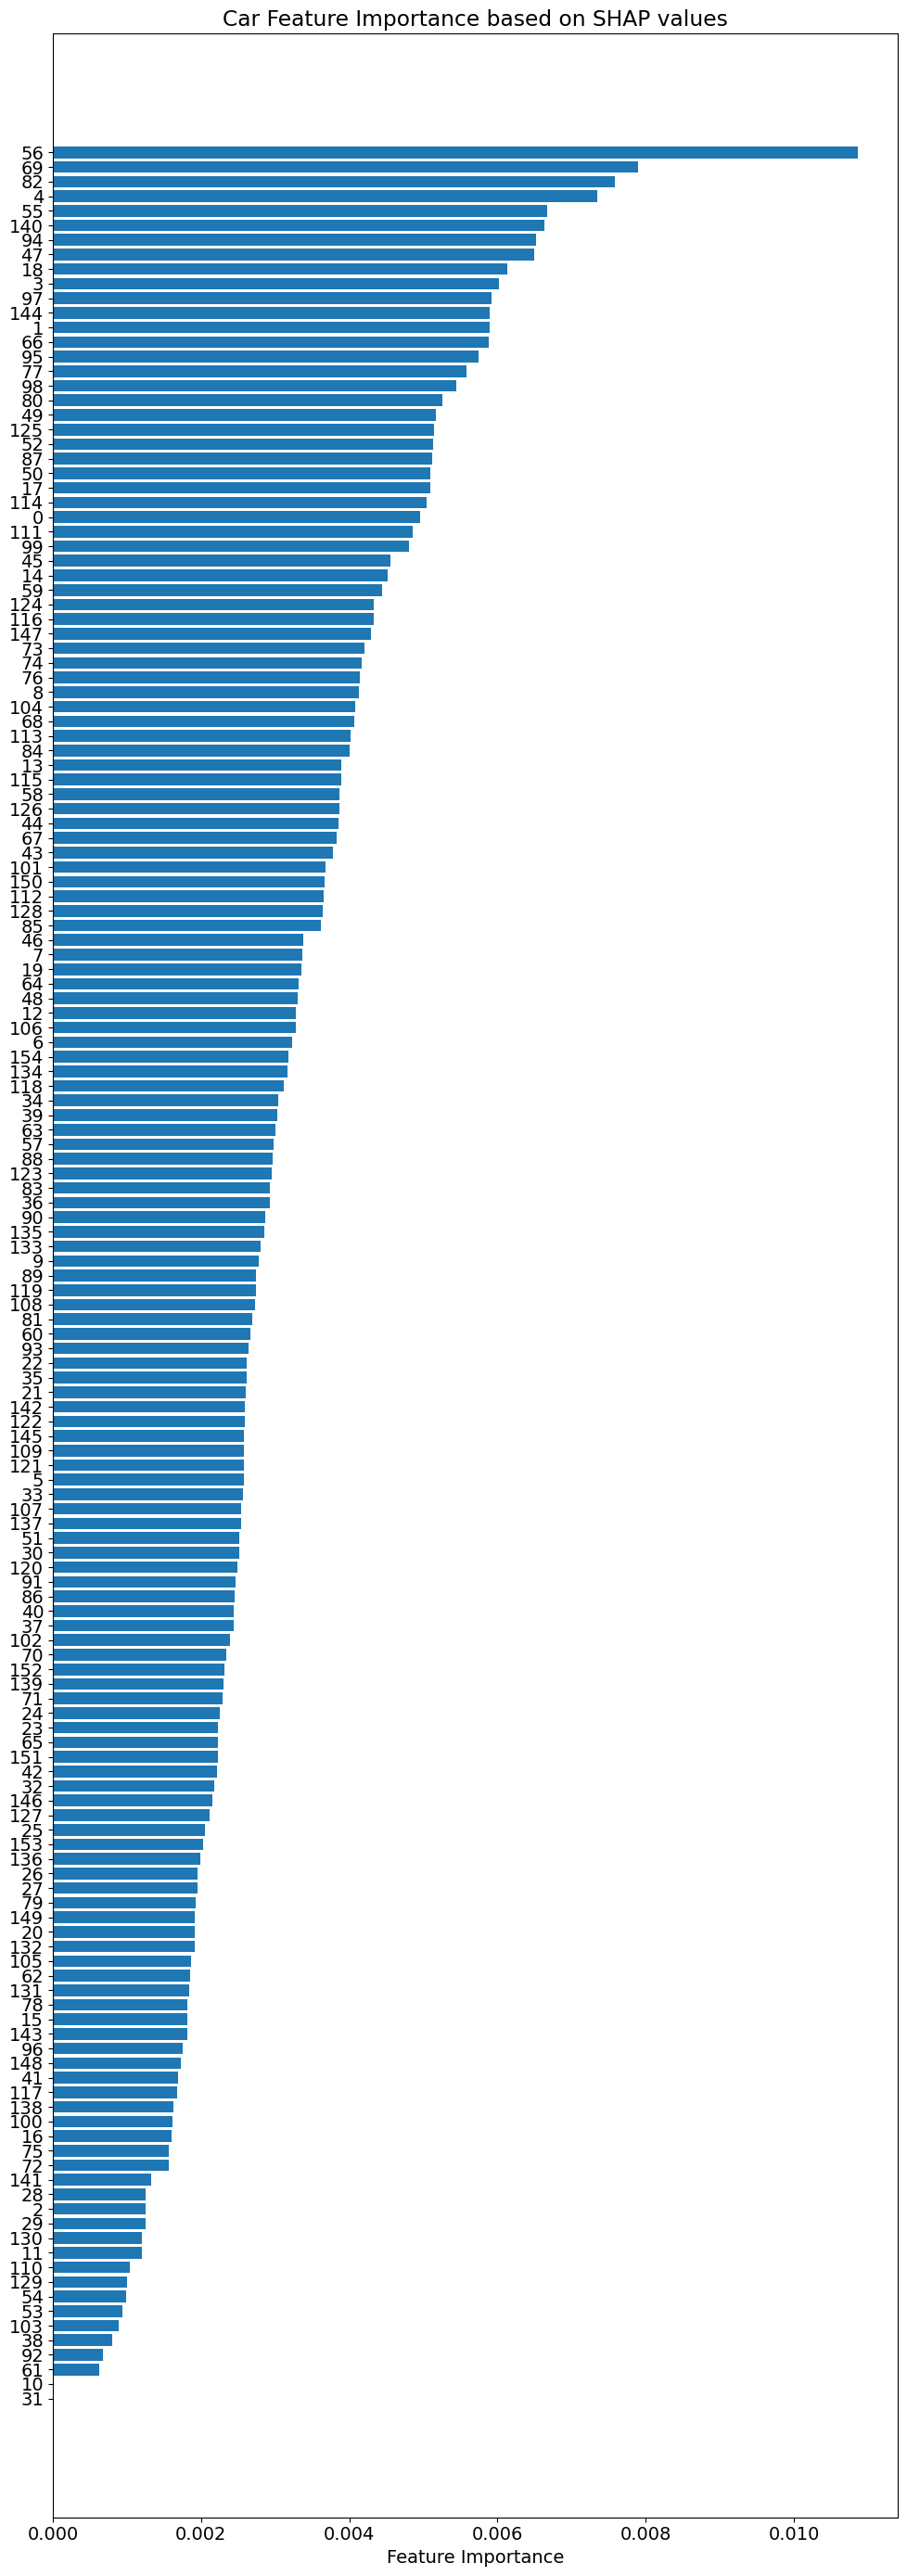

In [60]:
# 绘制用户特征重要性
plt.figure(figsize=(10, 8))
sorted_idx_user = meanab_shap_user.argsort()
plt.barh(range(user_train.shape[1]), meanab_shap_user[sorted_idx_user])
plt.yticks(range(user_train.shape[1]), sorted_idx_user)
plt.xlabel('Feature Importance')
plt.title('User Feature Importance based on SHAP values')
plt.tight_layout()
plt.show()

# 绘制汽车特征重要性
plt.figure(figsize=(10, 28))
sorted_idx_car = meanab_shap_car.argsort()
plt.barh(range(car_train.shape[1]), meanab_shap_car[sorted_idx_car])
plt.yticks(range(car_train.shape[1]), sorted_idx_car)
plt.xlabel('Feature Importance')
plt.title('Car Feature Importance based on SHAP values')
plt.tight_layout()
plt.show()


In [61]:
# 计算SHAP值的平均
mean_shap_user = shap_values[0][0].mean(axis=0)
mean_shap_car = shap_values[0][1].mean(axis=0)

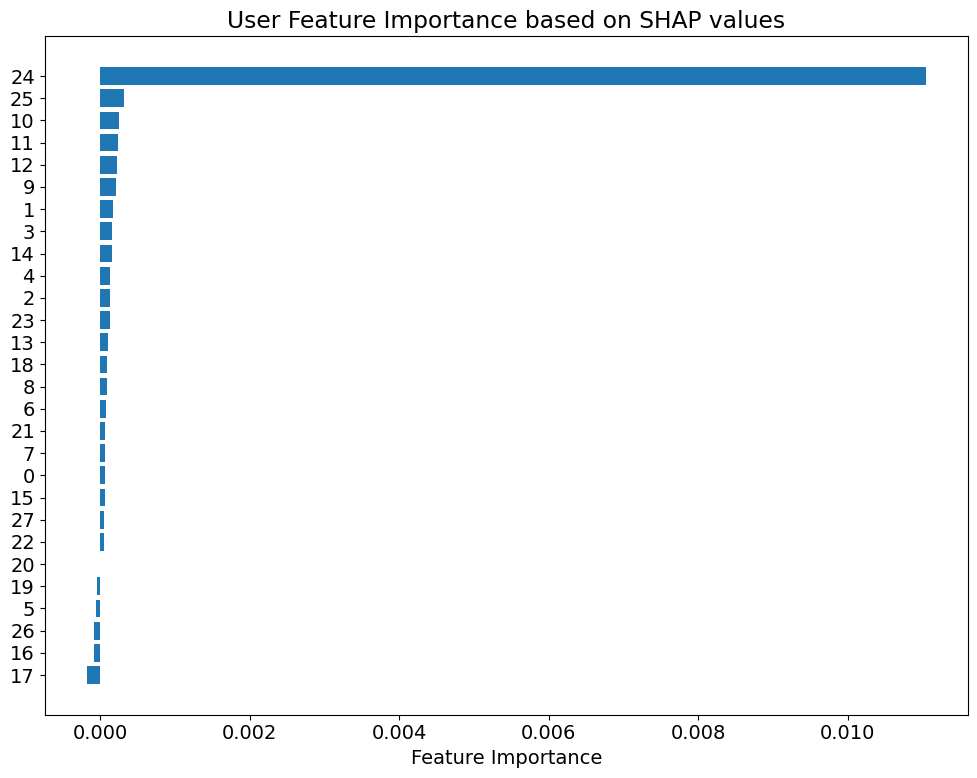

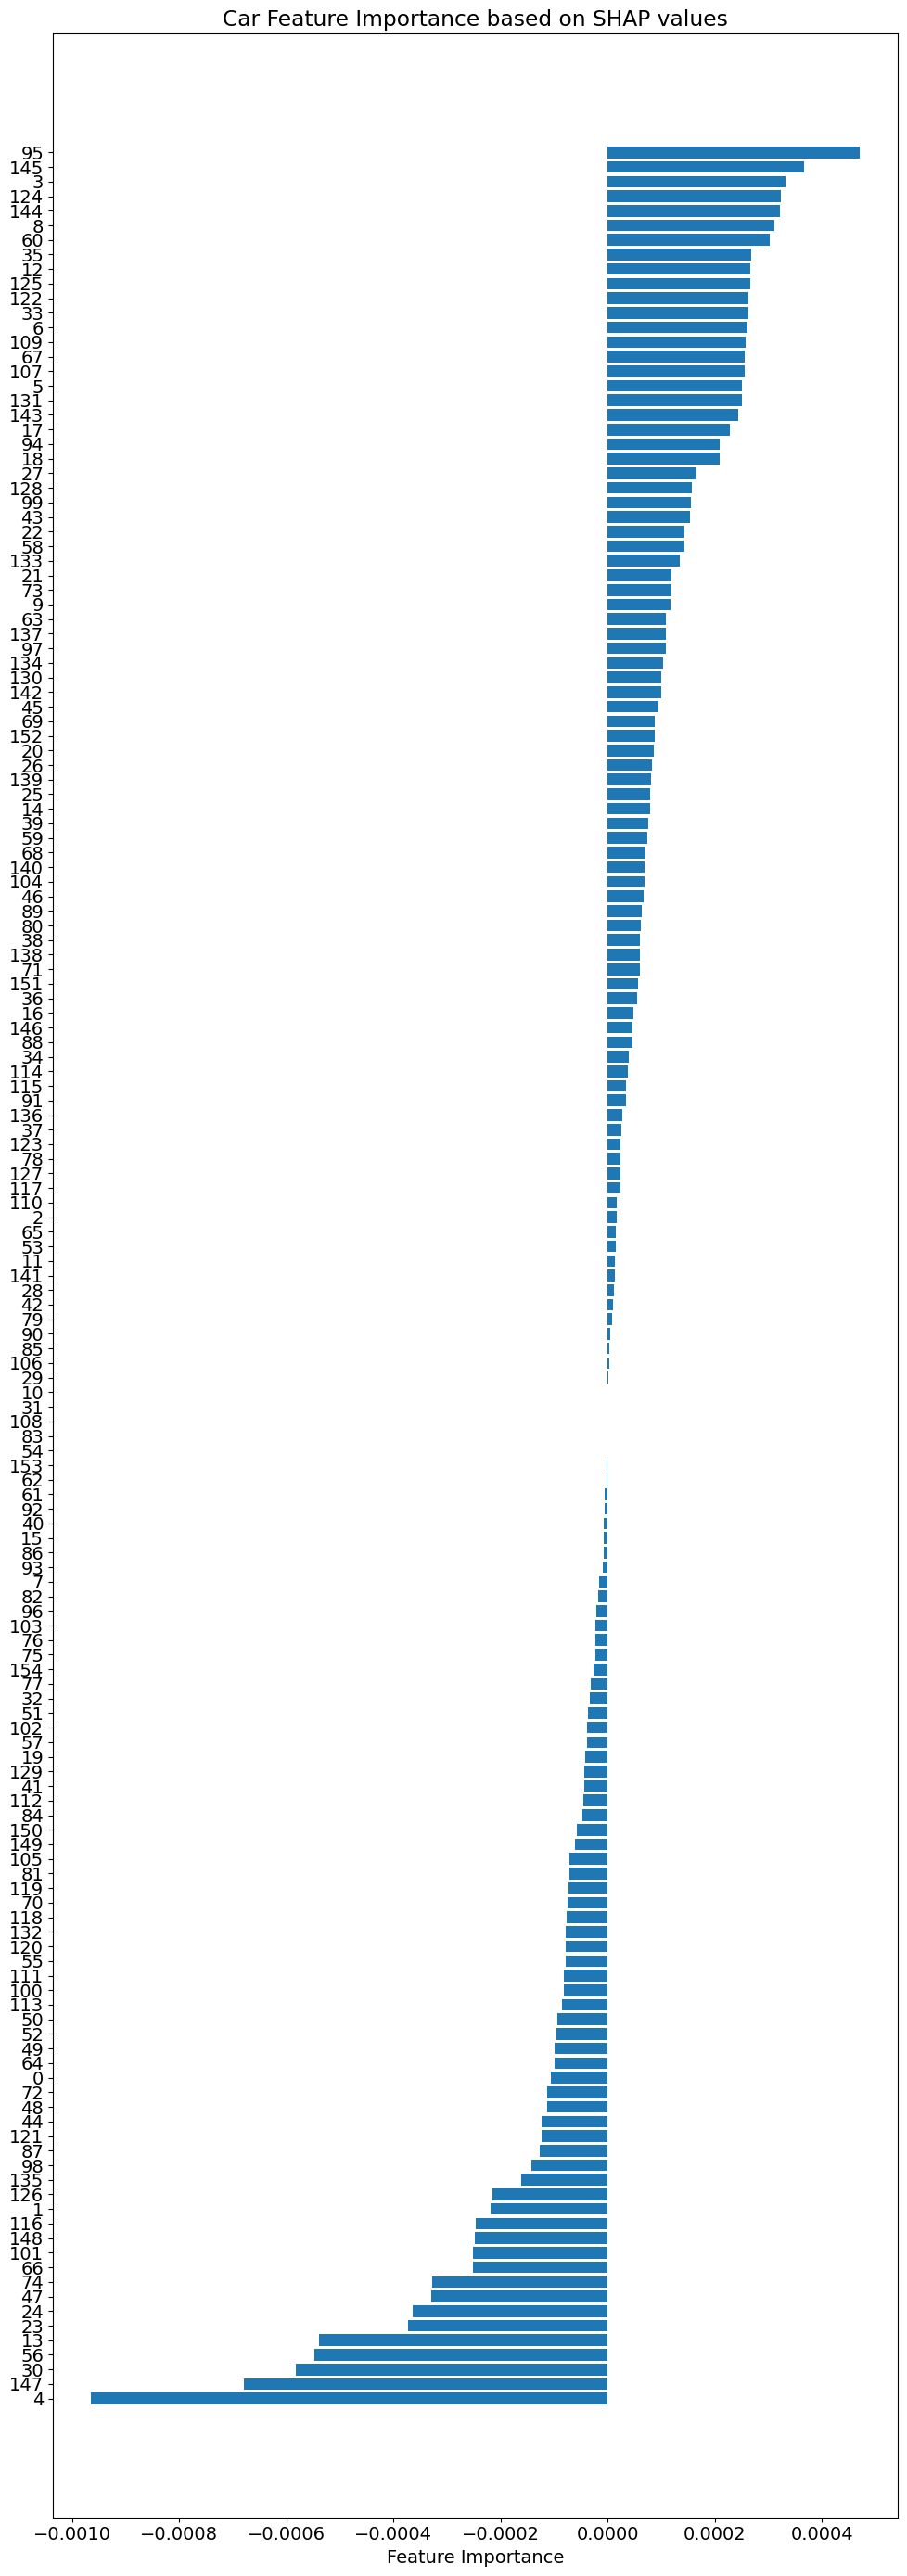

In [62]:
# 绘制用户特征重要性
plt.figure(figsize=(10, 8))
sorted_idx_user = mean_shap_user.argsort()
plt.barh(range(user_train.shape[1]), mean_shap_user[sorted_idx_user])
plt.yticks(range(user_train.shape[1]), sorted_idx_user)
plt.xlabel('Feature Importance')
plt.title('User Feature Importance based on SHAP values')
plt.tight_layout()
plt.show()

# 绘制汽车特征重要性
plt.figure(figsize=(10, 28))
sorted_idx_car = mean_shap_car.argsort()
plt.barh(range(car_train.shape[1]), mean_shap_car[sorted_idx_car])
plt.yticks(range(car_train.shape[1]), sorted_idx_car)
plt.xlabel('Feature Importance')
plt.title('Car Feature Importance based on SHAP values')
plt.tight_layout()
plt.show()


In [63]:
shap_values[0][0][0]

array([-2.24272441e-03,  1.98578066e-03, -6.08975627e-03,  6.03143265e-03,
       -5.84273739e-03,  1.67238992e-03,  1.91066470e-02,  1.38092460e-03,
        2.33689025e-02, -4.68500666e-02, -1.27715766e-02,  2.17195731e-02,
        1.87941609e-04,  7.76474224e-03, -2.09369175e-02, -4.35724185e-04,
        1.60687650e-03,  0.00000000e+00,  6.12601929e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -6.56375755e-03, -4.46593016e-03,
       -4.43193883e-01, -1.18379341e-02, -2.21731160e-02,  4.55886038e-04])

基于全市场的单一用户的影响购买因素倾向分析

In [64]:
num_cars_pre

142

In [65]:
num_users_pre

5520

In [66]:
user_pre_vecs.shape

(12144, 28)

In [67]:
# 选取需要分析的用户
id_user = 1000

In [68]:
# 该用户的数据
scalerUser.inverse_transform(user_pre_vecs[id_user, :].reshape(1, -1)).astype(int)

array([[  3,   3,   3,   3,   3,   3,   3,   3,   1,   0,   0,   0,   0,
          1,   0,   0,   0,   0,   0,   0,   0,   0, 800,  60,  47,   2,
          1,  21]])

In [69]:
# 使用模型对背景数据进行预测以获取基准值
background_predictions = model.predict([background_data_user, background_data_car])

# 使用背景数据的输出均值作为基准值
expected_value = background_predictions.mean()

# 创建一个Explanation对象（用户特征）
expl_user = shap.Explanation(values=shap_values[0][0][id_user],
                        base_values=expected_value,
                        data=user_pre_vecs[id_user, :],
                        feature_names=dsc_up_pre_features) # 请提供特征名称列表

272/272 [==============================] - 1s 2ms/step


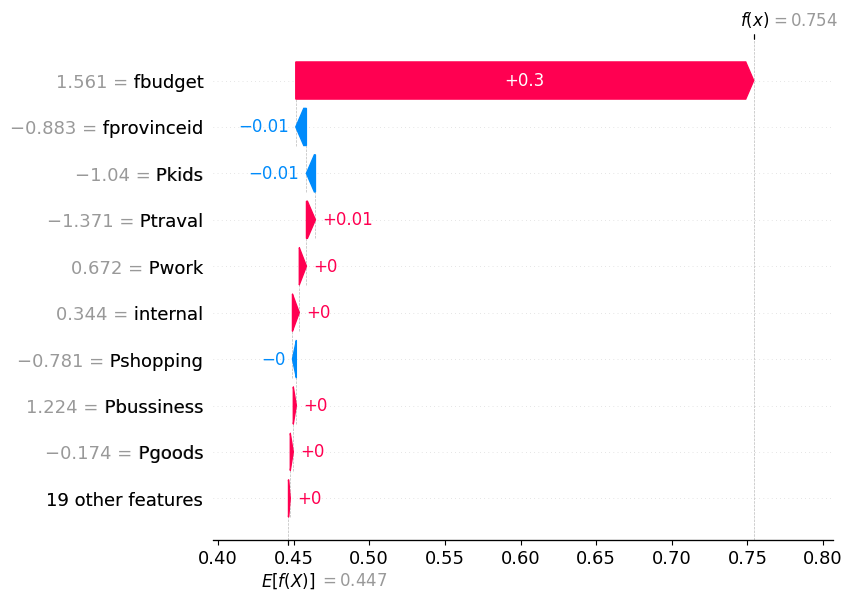

In [70]:
# 可视化这个解释
shap.plots.waterfall(expl_user)

基于全市场的单一车型参数的影响购买因素倾向分析

In [71]:
car_pre_vecs.shape

(12144, 155)

In [72]:
# 选取需要分析的车型
id_car = 1000

In [73]:
# 该车型的数据
scalerCar.inverse_transform(car_pre_vecs[id_car, :].reshape(1, -1)).astype(int)

array([[  44,    5,    1,    4,    6,   15,    0,    6,  102,  231,    1,
         180,    7,  180,  970,    2,    0,    7,    1,  292,  450,  170,
         340,   45,  110,    2,    2,    3,    0,    0,    2,    1,    2,
           1,    0,    1, 5250, 1960, 1920, 3110, 1675, 1675, 2665,    7,
           1,    2,    1,    1,    1,    2,    2,    2,    2,    1,    1,
           3,    1,    5,    4,    2,    1,    0,    2,    3,    2,    0,
           2,    6,    3,    1,    2,    0,    1,    1,    1,    1,    3,
           5,    4,    1,    2,    4,    2,    1,    6,    0,    1,    1,
           2,    1,    0,    5,    0,    2,    1,    1,    2,    4,    1,
           0,    2,   14,    2,    1,    1,    1,    0,    1,    1,    1,
           4,    3,    9,    2,    1,    2,    1,    2,    1,    1,    1,
           2,    1,    2,    8,    2,    1,   15,    2,    2,    1,    1,
           3,    2,  410, 2310,    2,    2,    2,    1,    0,    0,    1,
           1,    1,    1,    5,   80, 

In [163]:
# 创建一个Explanation对象（车型特征）
expl_car = shap.Explanation(values=shap_values[0][0][id_car],
                        base_values=expected_value,
                        data=car_pre_vecs[id_car, :],
                        feature_names=car_dict_pre_features) # 请提供特征名称列表

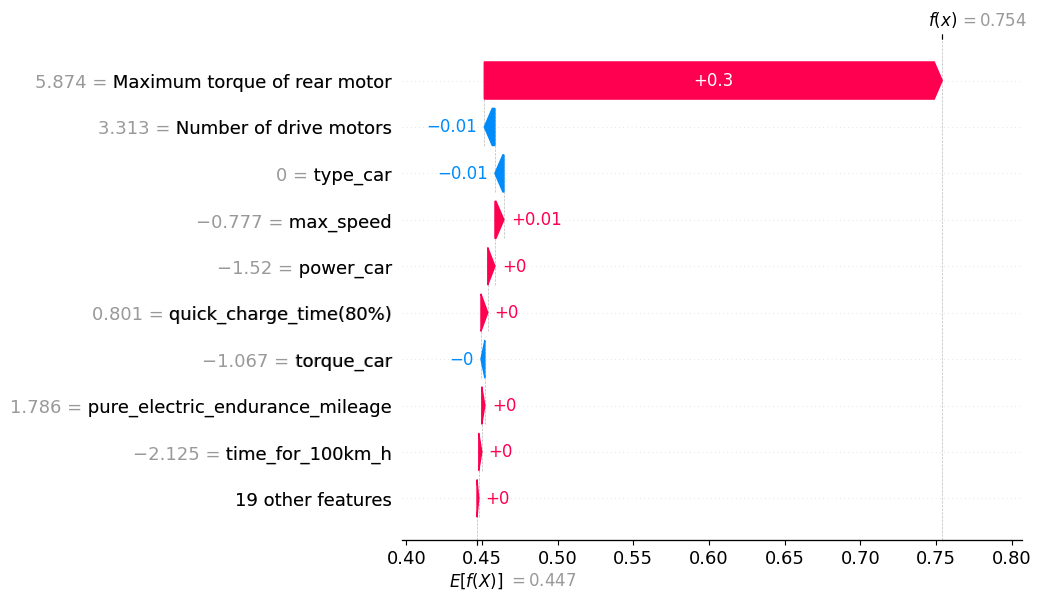

In [164]:
# 可视化这个解释
shap.plots.waterfall(expl_car)

全市场全特征分析

In [76]:
# 创建一个Explanation对象（用户特征）
expl_user_all = shap.Explanation(values=shap_values[0][0],
                        base_values=expected_value,
                        data=user_pre_vecs,
                        feature_names=dsc_up_pre_features) # 请提供特征名称列表

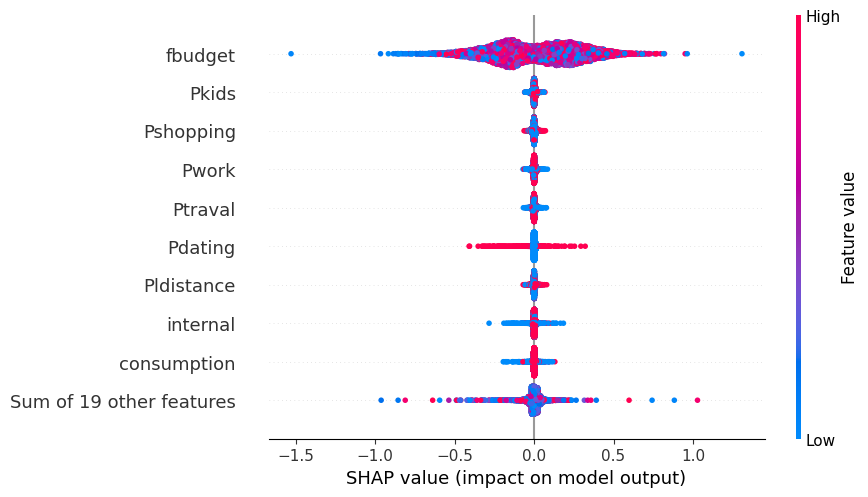

In [77]:
# summarize the effects of all the features
shap.plots.beeswarm(expl_user_all)

In [123]:
# 创建一个Explanation对象（车型特征）
expl_car_all = shap.Explanation(values=shap_values[0][1],
                        base_values=expected_value,
                        data=car_pre_vecs,
                        feature_names=car_dict_pre_features) # 请提供特征名称列表

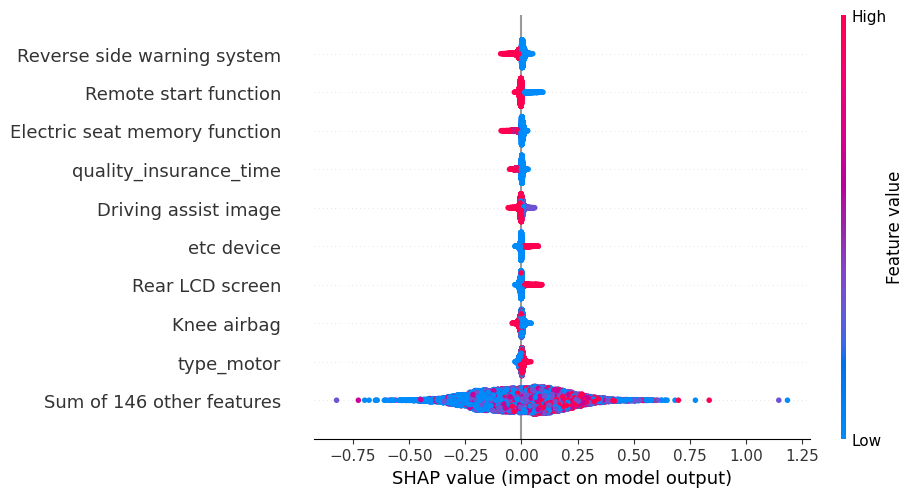

In [124]:
# summarize the effects of all the features
shap.plots.beeswarm(expl_car_all)

# *E8特征分析*

In [80]:
new_user_scal.shape

(4945, 28)

In [81]:
new_car_scal.shape

(4945, 155)

In [128]:
background_data_user_e8 = user_pre_vecs
background_data_car_e8 = car_pre_vecs

In [129]:
explainer_e8 = shap.GradientExplainer(model, [background_data_user_e8, background_data_car_e8])

In [130]:
shap_values_e8 = explainer_e8([new_user_scal, new_car_scal])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [165]:
type(shap_values[0][0])

numpy.ndarray

In [166]:
type(shap_values_e8[0][0])

shap._explanation.Explanation

In [131]:
# 查看数据结构
print(type(shap_values_e8))
print(len(shap_values_e8))

# 我们只检查第一个元素，因为您的输出显示shap_values的长度为1
first_element = shap_values_e8[0]
print(type(first_element))
print(len(first_element))

# 现在我们看看这个列表的内容
for inner_value in first_element:
    print(type(inner_value))
    if isinstance(inner_value, np.ndarray):  # 如果它是一个ndarray，我们打印它的形状
        print(inner_value.shape)
    else:
        print(inner_value)  # 否则我们直接打印它的值

<class 'shap._explanation.Explanation'>
1
<class 'shap._explanation.Explanation'>
2
<class 'shap._explanation.Explanation'>
.values =
array([[ 4.62059033e-05, -2.51737307e-03, -7.96247274e-04, ...,
         3.96448933e-03, -7.39657436e-04,  9.58371966e-04],
       [ 3.46431881e-02, -6.96727249e-04,  4.63016477e-04, ...,
        -1.33936591e-02,  3.78293311e-03, -2.36741907e-04],
       [-1.32208201e-03, -7.29401177e-03,  5.44407172e-04, ...,
         9.70140914e-04, -3.74496845e-03,  5.41065063e-04],
       ...,
       [ 2.45427783e-03,  5.62272849e-04, -3.10444203e-03, ...,
        -7.40905711e-03,  6.26235036e-04,  2.34178849e-04],
       [-1.22593238e-03,  1.94048404e-03,  4.39055217e-03, ...,
         2.60116620e-04, -9.08039219e-04, -2.52052699e-03],
       [ 4.45263868e-04,  4.74866256e-02, -1.67176465e-03, ...,
         9.41971689e-03,  9.24097933e-03, -2.22736300e-04]])

.data =
array([-0.02046554, -1.97022429,  0.67958484,  0.35302682, -5.10484623,
        3.23425268,  0.34396

In [132]:
# 计算SHAP值的平均
mean_shap_user_e8 = shap_values_e8[0][0].mean(axis=0)
mean_shap_car_e8 = shap_values_e8[0][1].mean(axis=0)

In [133]:
mean_shap_user_e8.values

array([ 6.42447255e-04,  3.53213810e-04,  1.62209077e-05,  5.35495364e-04,
       -2.50704636e-04,  1.50728095e-04, -2.71846741e-04,  7.70454870e-04,
        9.46710468e-04,  9.30643112e-04,  2.80632157e-04,  6.50255093e-04,
        6.05318435e-04,  6.95362631e-04,  9.75918013e-04,  9.43904564e-04,
        2.36909060e-04,  1.32786312e-04,  1.61642759e-04, -3.16593328e-04,
        0.00000000e+00, -2.35228569e-04, -4.35473089e-04,  2.36094493e-04,
       -1.59139208e-01, -5.06155814e-04, -8.48951193e-05,  3.18664746e-04])

In [134]:
mean_shap_car_e8.values

array([ 2.36628133e-03,  3.84171704e-03, -5.16898155e-04,  1.02537580e-02,
        1.96052535e-03, -3.29974086e-04,  2.54141547e-03,  5.29213596e-03,
        4.20880812e-03,  2.78129602e-03,  0.00000000e+00,  5.08193085e-04,
       -1.72390775e-04, -2.32536443e-03,  9.25741029e-04,  6.70064626e-05,
        5.90151787e-04, -7.97187221e-03,  4.84568749e-03,  1.68375145e-03,
        1.44909475e-03,  2.25522143e-03,  2.58392075e-03,  1.20044302e-03,
        1.21752721e-03,  1.34968820e-03,  1.18680222e-03,  1.60286473e-03,
        4.71141615e-04,  6.50690687e-04,  1.30680904e-03,  0.00000000e+00,
       -3.24473973e-04,  8.14665327e-03,  1.61643470e-03,  8.00092742e-03,
        1.05082916e-04,  9.42182428e-04, -2.38555166e-04,  2.24060116e-04,
        7.94315811e-04,  9.18024174e-04,  3.24369766e-03,  2.22289413e-03,
       -2.81900787e-03,  1.01690678e-03,  7.30322482e-03,  3.60413744e-03,
        1.59423862e-03, -3.32698313e-03, -3.17362469e-03, -2.87142397e-03,
       -3.36182221e-03, -

In [137]:
dsc_up_pre_features

['space',
 'power',
 'maneuverability',
 'consumption',
 'comfortableness',
 'apperance',
 'internal',
 'costefficient',
 'Pwork',
 'Pshopping',
 'Pkids',
 'Ptraval',
 'Pgoods',
 'Pbussiness',
 'Pldistance',
 'Pdating',
 'Pcross',
 'Pracing',
 'Pnettaxi',
 'Prefit',
 'Pteam',
 'Pgirl',
 'fdrivenkiloms',
 'fcityid',
 'fbudget',
 'fprovinceid',
 'driving _months',
 'km/d']

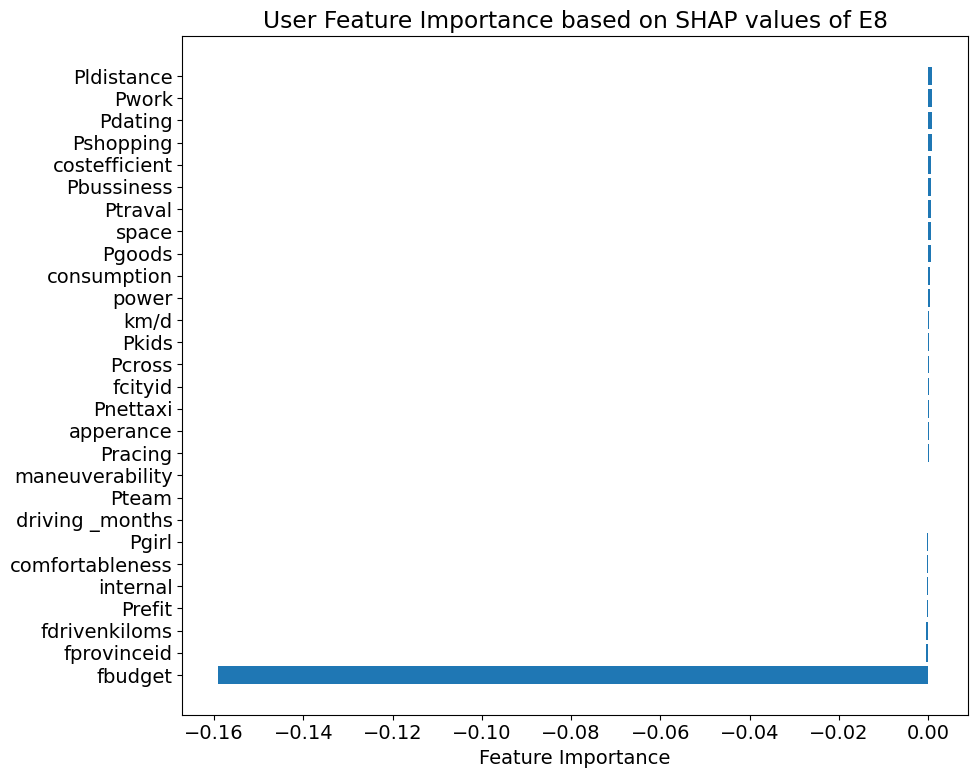

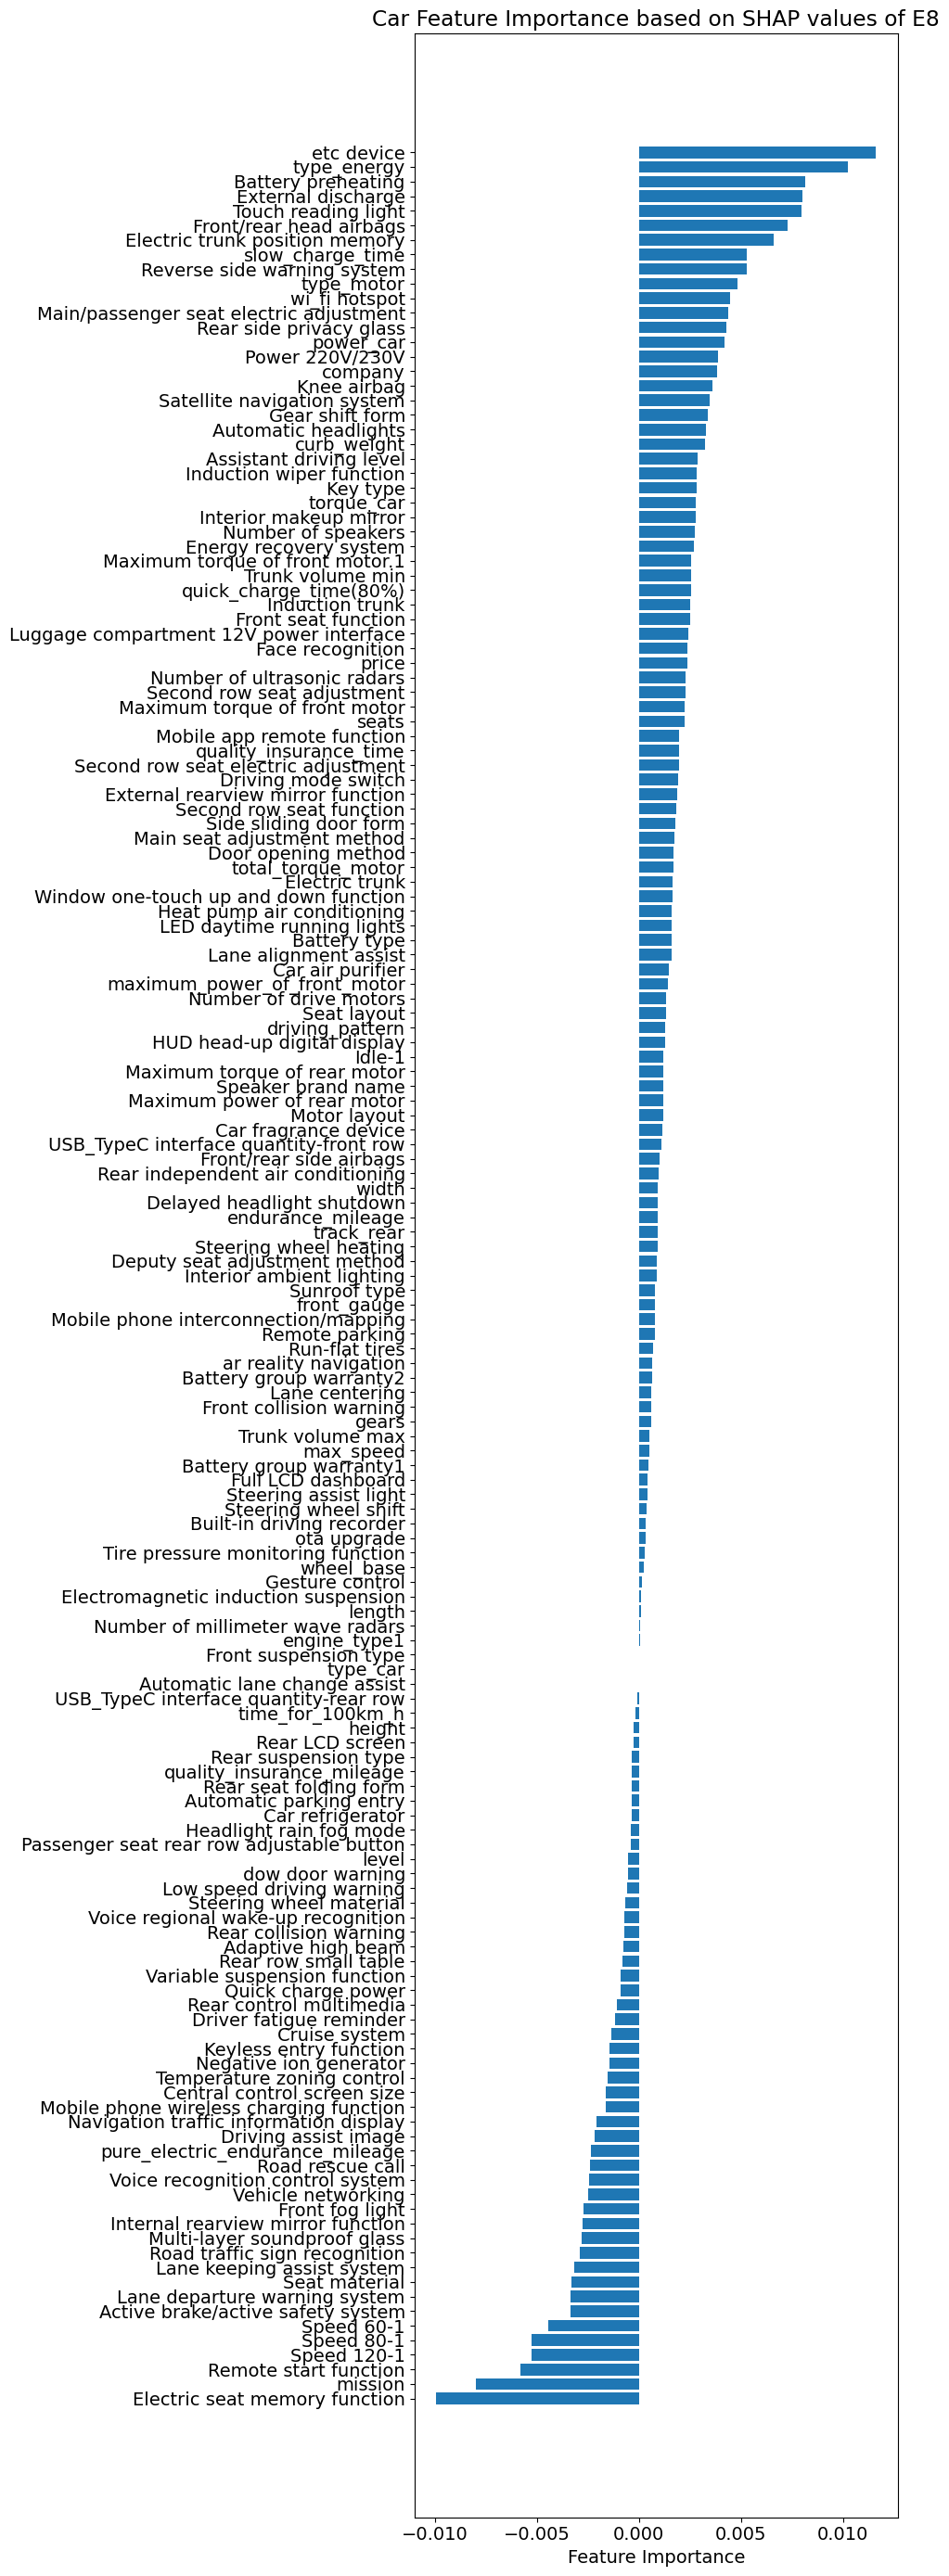

In [138]:
# 绘制用户特征重要性
plt.figure(figsize=(10, 8))
sorted_idx_user = mean_shap_user_e8.values.argsort()
plt.barh(range(new_user_scal.shape[1]), mean_shap_user_e8.values[sorted_idx_user])
plt.yticks(range(new_user_scal.shape[1]), [dsc_up_pre_features[i] for i in sorted_idx_user])
plt.xlabel('Feature Importance')
plt.title('User Feature Importance based on SHAP values of E8')
plt.tight_layout()
plt.show()

# 绘制汽车特征重要性
plt.figure(figsize=(10, 28))
sorted_idx_car = mean_shap_car_e8.values.argsort()
plt.barh(range(new_car_scal.shape[1]), mean_shap_car_e8.values[sorted_idx_car])
plt.yticks(range(new_car_scal.shape[1]), [car_dict_pre_features[i] for i in sorted_idx_car])
plt.xlabel('Feature Importance')
plt.title('Car Feature Importance based on SHAP values of E8')
plt.tight_layout()
plt.show()


In [139]:
# 使用模型对背景数据进行预测以获取基准值
background_predictions = model.predict([background_data_user, background_data_car])

# 使用背景数据的输出均值作为基准值
expected_value = background_predictions.mean()



272/272 [==============================] - 0s 1ms/step


In [140]:
# 选取需要分析的用户
id_user_e8 = 1000

In [141]:
# 该用户的数据
scalerUser.inverse_transform(new_user_scal[id_user_e8, :].reshape(1, -1)).astype(int)

array([[   3,    3,    2,    2,    1,    3,    2,    3,    1,    0,    0,
           0,    0,    1,    1,    0,    0,    0,    0,    0,    0,    0,
        6500,    5,   31,   10,    6,   31]])

In [147]:
shap_values_e8.shape

(1, 2, 4945, None)

In [143]:
new_user_scal.shape

(4945, 28)

In [182]:
shap_values_e8[0][0].values[id_user_e8, :]

array([-7.58130918e-04, -5.70259115e-04,  1.40166394e-02, -3.84647995e-02,
        4.89518093e-03, -4.93424886e-04,  1.45294322e-02,  3.16596939e-04,
        9.81665030e-03,  5.05195837e-03,  2.02965569e-02,  1.20565416e-02,
        1.70225021e-03, -8.12896993e-03,  6.97010616e-03,  3.36711132e-03,
       -1.44411356e-03,  0.00000000e+00,  1.10788888e-03, -1.99907035e-10,
        0.00000000e+00,  0.00000000e+00, -8.34144838e-03, -3.00287232e-02,
        1.76270194e-02,  1.05819516e-02, -2.20257267e-02, -6.07686059e-04])

In [180]:
print(type(shap_values_e8[0][0]))

<class 'shap._explanation.Explanation'>


In [145]:
new_user_scal[id_user_e8, :]

array([-0.02046554,  0.23103172, -0.90857539, -1.48844746, -3.28063286,
        0.1239105 , -1.7585336 ,  0.1498513 ,  0.6718806 , -0.78083322,
       -1.0398216 , -1.37113942, -0.17380545,  1.22422904,  1.34999577,
       -0.20098642, -0.09365858, -0.04932136, -0.11082643, -0.07409478,
        0.        , -0.02011498,  0.55576234, -1.582685  ,  0.16187777,
        0.24552509,  0.96203952, -0.13862524])

In [183]:
# 创建一个Explanation对象（用户特征）
expl_user_e8 = shap.Explanation(values=shap_values_e8[0][0].values[id_user_e8],
                        base_values=expected_value,
                        data=new_user_scal[id_user_e8],
                        feature_names=dsc_up_pre_features) # 用户特征名称列表


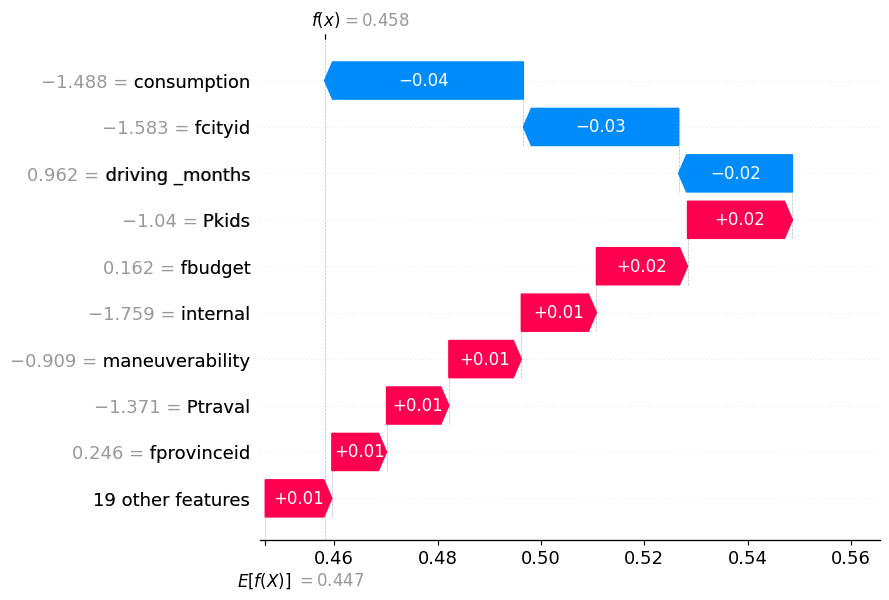

In [184]:
# 可视化这个解释
shap.plots.waterfall(expl_user_e8)

In [185]:
# 选取需要分析的车型
id_car_e8 = 100

In [186]:
# 该车型的数据
scalerCar.inverse_transform(new_car_scal[id_car_e8, :].reshape(1, -1)).astype(int)

array([[  25,    1,    2,    4,    3,   10,    0,    4,  103,  180,    1,
         170,    9,  116,  950,    8,    1,    1,    1,  134,  300,  134,
         300,    0,    0,    1,    1,    2,    8,   15,    1,    1,    1,
           1,    0,    1, 4920, 1900, 1760, 2930, 1618, 1640, 2175,    7,
           2,    1,    2,    0,    0,    2,    2,    2,    2,    1,    1,
           3,    0,    5,    3,    1,    0,    0,    3,    3,    2,    1,
           0,    3,    1,    1,    2,    0,    0,    1,    0,    0,    1,
           1,    3,    1,    2,    3,    1,    0,    2,    0,    1,    1,
           2,    1,    2,    5,    0,    2,    0,    0,    3,    3,    1,
           0,    0,    8,    2,    1,    1,    1,    0,    0,    1,    1,
           3,    3,    4,    1,    1,    2,    1,    2,    1,    1,    0,
           0,    0,    1,    4,    2,    1,   14,    2,    0,    0,    0,
           3,    2,  344, 1300,    0,    2,    2,    1,    0,    0,    0,
           0,    1,    3,    1,   39, 

In [188]:
# 创建一个Explanation对象（车型特征）
expl_car_e8 = shap.Explanation(values=shap_values_e8[0][1].values[id_car_e8],
                        base_values=expected_value,
                        data=new_car_scal[id_car_e8, :],
                        feature_names=car_dict_pre_features) # 请提供特征名称列表

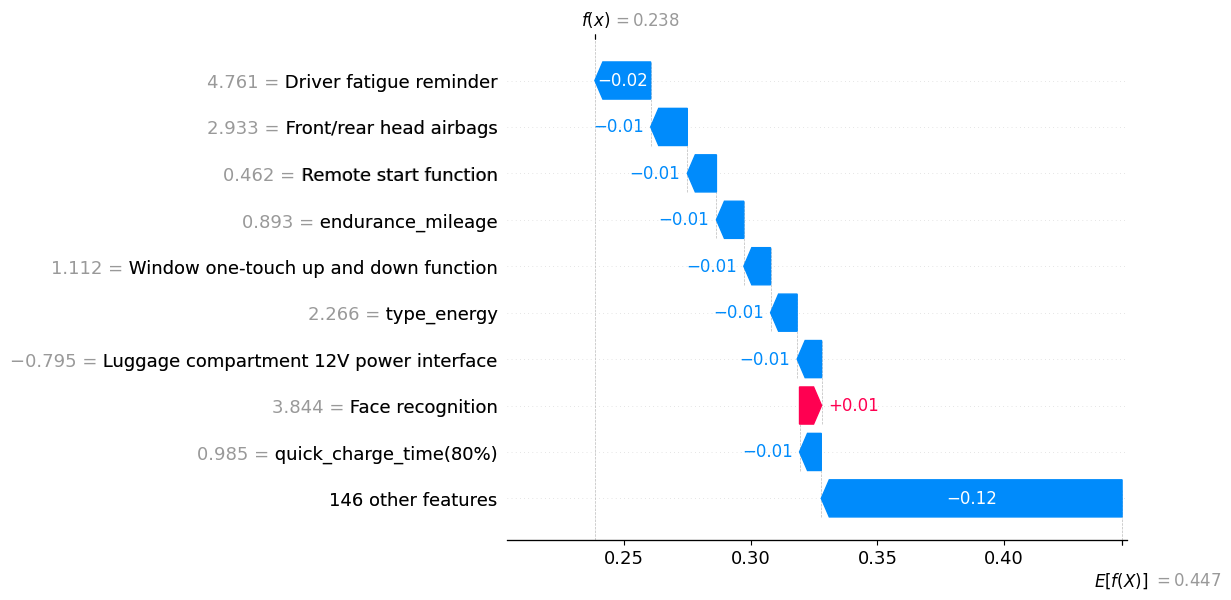

In [189]:
# 可视化这个解释
shap.plots.waterfall(expl_car_e8)

基于E8车型，全量特征分析

In [190]:
# 创建一个Explanation对象（用户特征）
expl_user_all_e8 = shap.Explanation(values=shap_values_e8[0][0].values,
                        base_values=expected_value,
                        data=new_user_scal,
                        feature_names=dsc_up_pre_features) # 用户特征名称列表

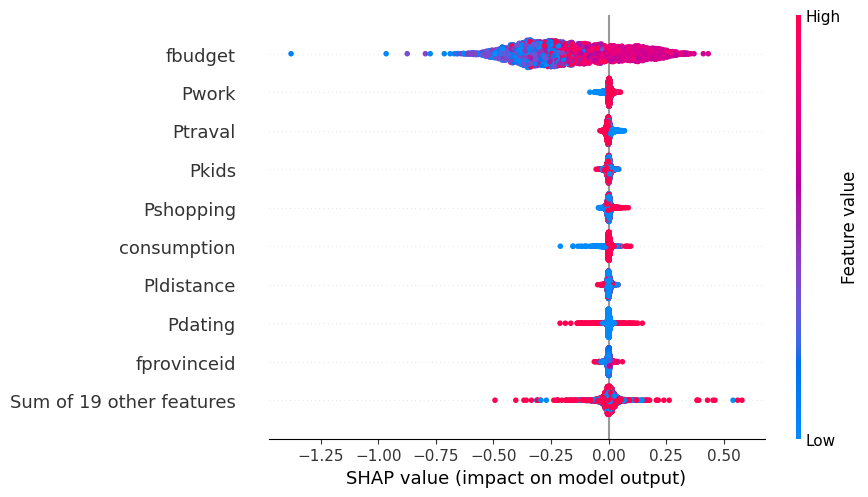

In [191]:
# summarize the effects of all the features
shap.plots.beeswarm(expl_user_all_e8)

In [193]:
# 创建一个Explanation对象（车型特征）
expl_car_all_e8 = shap.Explanation(values=shap_values_e8[0][1].values,
                        base_values=expected_value,
                        data=new_car_scal,
                        feature_names=car_dict_pre_features) # 车型特征名称列表

In [195]:
shap_values_e8[0][1].values

array([[-2.01094337e-03,  2.35482375e-03,  3.06497619e-04, ...,
         4.87043522e-04, -1.17587484e-03, -1.46353652e-03],
       [-1.49353594e-03,  2.96379556e-03,  3.72118593e-05, ...,
        -2.72217556e-04, -3.49379517e-03, -2.13098596e-03],
       [-8.96284590e-04,  1.51500106e-03, -1.33704947e-04, ...,
         2.01821001e-03,  1.85828621e-03,  1.19158858e-03],
       ...,
       [ 1.57319114e-03,  4.55767708e-03, -2.94398051e-03, ...,
        -6.07644301e-03,  1.56782044e-03, -5.23106614e-03],
       [ 2.68697925e-03,  5.29206917e-03, -2.38230336e-03, ...,
        -4.00148239e-03,  8.55772872e-04, -2.71652546e-03],
       [ 3.48588161e-04,  5.84572507e-03, -3.18305404e-03, ...,
        -3.88947851e-03,  5.19094011e-03,  5.21090173e-04]])

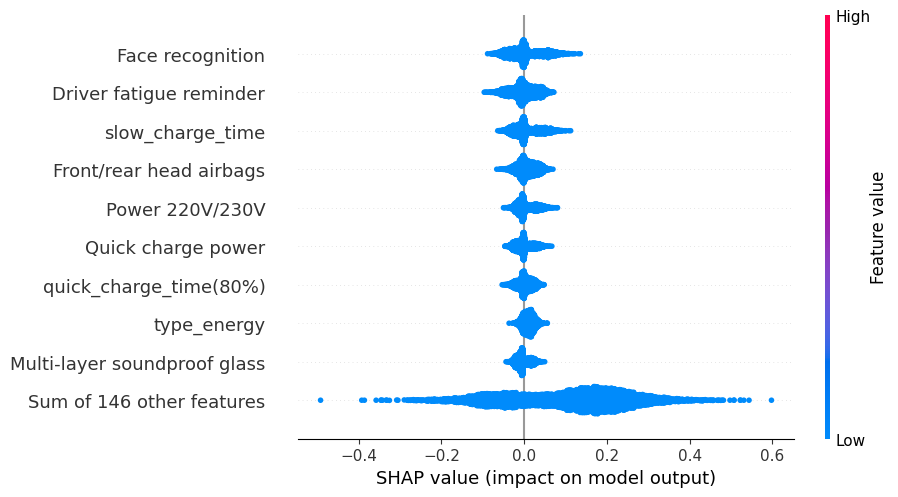

In [194]:
# summarize the effects of all the features
shap.plots.beeswarm(expl_car_all_e8)

In [ ]:
# 创建解释器时
explainer3 = shap.PermutationExplainer(model, [background_data_user_e8, background_data_car_e8], max_evals=5000)

# 计算SHAP值
shap_values3 = explainer.shap_values([new_user_scal, new_car_scal])


StagingError: ignored

In [ ]:
shap_values_e8 = shap_values3

In [ ]:
background_data_car_e8

array([[-0.21636947, -0.80437031,  0.90195077, ...,  2.46441639,
         3.31725385,  1.75083885],
       [-0.21636947, -0.80437031,  0.90195077, ...,  2.46441639,
         3.31725385,  1.75083885],
       [-0.21636947, -0.80437031,  0.90195077, ...,  2.46441639,
         3.31725385,  1.75083885],
       ...,
       [-0.21636947, -0.80437031,  0.90195077, ...,  2.46441639,
         3.31725385,  1.75083885],
       [-0.21636947, -0.80437031,  0.90195077, ...,  2.46441639,
         3.31725385,  1.75083885],
       [-0.21636947, -0.80437031,  0.90195077, ...,  2.46441639,
         3.31725385,  1.75083885]])

In [ ]:
shap_values_e8 = explainer2.shap_values([background_data_user_e8, background_data_car_e8])

In [ ]:
print(type(shap_values_e8))
print(len(shap_values_e8))

# 我们只检查第一个元素，因为您的输出显示shap_values的长度为1
first_element = shap_values_e8[0]
print(type(first_element))
print(len(first_element))

# 现在我们看看这个列表的内容
for inner_value in first_element:
    print(type(inner_value))
    if isinstance(inner_value, np.ndarray):  # 如果它是一个ndarray，我们打印它的形状
        print(inner_value.shape)
    else:
        print(inner_value)  # 否则我们直接打印它的值



<class 'list'>
1
<class 'list'>
2
<class 'numpy.ndarray'>
(3000, 28)
<class 'numpy.ndarray'>
(3000, 155)


In [ ]:
shap_values_e8

[[array([[-1.86575414e-03, -1.31368414e-02, -6.88059081e-04, ...,
           1.51685241e-03, -3.95528332e-04,  2.06832658e-03],
         [-5.93254855e-03, -4.55124245e-05, -3.81591893e-03, ...,
          -8.85180756e-03, -6.88553380e-04, -3.19920189e-04],
         [ 3.04240297e-04, -3.67832812e-03,  1.15439318e-04, ...,
          -8.06580239e-04,  6.53448951e-05,  1.33706687e-03],
         ...,
         [-1.95924862e-04, -3.21648200e-04,  1.74790469e-03, ...,
           2.68195639e-03, -1.99157745e-03, -4.88398643e-03],
         [ 2.22242647e-03,  7.53576634e-04,  1.12312962e-03, ...,
           1.23227225e-03, -1.34120369e-03, -1.38965307e-03],
         [-1.64737110e-03,  2.37477068e-02,  2.52700248e-03, ...,
          -8.29770113e-04,  1.35373281e-04,  2.91919569e-03]]),
  array([[-4.01745457e-03,  4.97278234e-04,  1.11628811e-04, ...,
           1.96995656e-03, -3.57777951e-03, -2.99346005e-03],
         [-6.34215632e-03,  1.66262535e-03, -1.87039928e-04, ...,
           2.77651916e

In [ ]:
# 计算SHAP值的平均
mean_shap_user_e8 = np.abs(shap_values_e8.values[0][0]).mean(axis=0)
mean_shap_car_e8 = np.abs(shap_values_e8.values[0][1]).mean(axis=0)

In [ ]:
shap_values_e8.shape

(1, 2, 4945, None)

In [ ]:
shap.plots.waterfall(shap_values_e8[0][0][0, :])

TypeError: ignored

In [ ]:
shap.plots.scatter(shap_values_e8[:, "Latitude"], color=shap_values)

ValueError: ignored

In [ ]:
mean_shap_car_e8

array([0.00374083, 0.00554091, 0.00131665, 0.01590315, 0.00170232,
       0.00052676, 0.0227109 , 0.02166091, 0.01813525, 0.01284198,
       0.        , 0.00501176, 0.00288306, 0.02175879, 0.04692729,
       0.00180544, 0.00333575, 0.0250046 , 0.01191458, 0.00404405,
       0.00556381, 0.00854091, 0.0104386 , 0.00130052, 0.00128882,
       0.00524531, 0.00545234, 0.00577803, 0.00554396, 0.00478242,
       0.00187204, 0.        , 0.00228403, 0.00828498, 0.00171381,
       0.00942192, 0.00248221, 0.00165149, 0.00105121, 0.00292727,
       0.00105364, 0.00119454, 0.0050774 , 0.0029366 , 0.02140402,
       0.00212674, 0.05068669, 0.00411229, 0.00613226, 0.00495485,
       0.00494955, 0.00765747, 0.00481685, 0.02085473, 0.00092069,
       0.00802778, 0.00675456, 0.00342827, 0.00162505, 0.00246747,
       0.00157287, 0.00095724, 0.00356065, 0.00411607, 0.00422605,
       0.00769177, 0.00410611, 0.02333672, 0.00604389, 0.00788342,
       0.00088275, 0.00082415, 0.00096472, 0.00428694, 0.00375